In [1]:
import cv2
print(f"OpenCV version: {cv2.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

OpenCV version: 4.11.0
PyTorch version: 2.6.0
CUDA available: True


In [2]:
import torch
import os
import gc

def check_gpu():
    print(f"CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
        print(f"Current GPU Device: {torch.cuda.current_device()}")
    else:
        print("No GPU detected. Running on CPU.")

check_gpu()

# CUDA configs
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()
gc.collect()

CUDA Available: True
Number of GPUs: 1
GPU Device Name: Tesla V100-SXM2-32GB
Current GPU Device: 0


107

# **Conversion Code**

In [4]:
# Import necessary libraries
import os
import json
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from collections import Counter

# Define paths - update these for your environment
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
EXTRACT_PATH = os.path.join(BASE_DIR, "IDD")
MASK_OUTPUT_DIR = os.path.join(EXTRACT_PATH, "IDD_pixelwise_masks")
VIS_OUTPUT_DIR = os.path.join(EXTRACT_PATH, "IDD_visualizations")

def process_split(split, gt_base, img_base, label_mapping, polygon_key):
    """
    Process a specific split (train or val)

    Args:
        split: Split name ('train' or 'val')
        gt_base: Path to gtFine directory
        img_base: Path to leftImg8bit directory
        label_mapping: Dictionary mapping labels to IDs
        polygon_key: Key to use for polygon data

    Returns:
        successful_masks: Number of successfully created masks
        visualization_count: Number of created visualizations
    """
    print(f"\nProcessing {split} split...")

    # Get the split directory
    split_dir = os.path.join(gt_base, split)
    if not os.path.exists(split_dir):
        print(f"Error: {split} directory not found: {split_dir}")
        return 0, 0

    # Get cities
    cities = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    print(f"Found {len(cities)} cities in {split} split: {cities}")

    # Count total JSON files
    total_json_files = 0
    for city in cities:
        city_dir = os.path.join(split_dir, city)
        json_files = glob.glob(os.path.join(city_dir, "*.json"))
        total_json_files += len(json_files)

    print(f"Found {total_json_files} JSON files in {split} split")

    # Process each city
    successful_masks = 0
    visualization_count = 0

    for city in cities:
        print(f"  Processing city: {city}")

        # Get JSON files for this city
        city_dir = os.path.join(split_dir, city)
        json_files = glob.glob(os.path.join(city_dir, "*.json"))

        # Process each JSON file
        for json_file in tqdm(json_files, desc=f"    {city}"):
            try:
                # Get ID part of the filename
                base_name = os.path.splitext(os.path.basename(json_file))[0]
                id_part = base_name.split('_')[0]

                # Create output mask path
                output_dir = os.path.join(MASK_OUTPUT_DIR, split, city)
                os.makedirs(output_dir, exist_ok=True)

                output_path = os.path.join(output_dir, f"{id_part}_mask.png")

                # Process the annotation
                success, used_labels = process_annotation(json_file, output_path, label_mapping, polygon_key)

                if success:
                    successful_masks += 1

                    # Find matching image file
                    img_dir = os.path.join(img_base, split, city)
                    img_files = glob.glob(os.path.join(img_dir, f"{id_part}_*.png"))

                    if img_files:
                        img_path = img_files[0]

                        # Create visualization
                        vis_dir = os.path.join(VIS_OUTPUT_DIR, split, city)
                        os.makedirs(vis_dir, exist_ok=True)

                        vis_path = os.path.join(vis_dir, f"{id_part}_visualization.png")
                        if create_visualization(output_path, img_path, vis_path):
                            visualization_count += 1
            except Exception as e:
                # Silently continue on errors to avoid cluttering the output
                continue

    print(f"Completed {split} split. Created {successful_masks} masks and {visualization_count} visualizations.")
    return successful_masks, visualization_count

def process_annotation(json_path, output_path, label_mapping, polygon_key='polygon'):
    """
    Process a single annotation file

    Args:
        json_path: Path to the JSON annotation file
        output_path: Path to save the mask
        label_mapping: Dictionary mapping labels to IDs
        polygon_key: Key to use for polygon data

    Returns:
        success: True if mask was created, False otherwise
        used_labels: Set of label IDs used in this mask
    """
    try:
        # Load the JSON file
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Check if this is a valid annotation file
        if 'imgHeight' not in data or 'imgWidth' not in data or 'objects' not in data:
            return False, set()

        img_height = data['imgHeight']
        img_width = data['imgWidth']

        # Create empty mask
        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # Track labels used
        used_labels = set()
        processed_count = 0

        # Process each object
        for obj in data['objects']:
            # Try multiple approaches to get label ID
            label_id = None

            # Try direct label_id
            if 'label_id' in obj and obj['label_id'] in label_mapping:
                label_id = label_mapping[obj['label_id']]
            # Try label name
            elif 'label' in obj and obj['label'] in label_mapping:
                label_id = label_mapping[obj['label']]
            # Try category_id (sometimes used in annotations)
            elif 'category_id' in obj and obj['category_id'] in label_mapping:
                label_id = label_mapping[obj['category_id']]
            else:
                # If we couldn't map the label, use a default
                label_id = 1

            # Skip background (0)
            if label_id == 0:
                continue

            used_labels.add(label_id)

            # Find polygon data - try multiple polygon keys
            polygon_data = None
            for key in [polygon_key, 'polygon', 'polygon_points', 'segmentation']:
                if key in obj and obj[key]:
                    polygon_data = obj[key]
                    break

            if polygon_data is None:
                continue

            # Convert polygon points to numpy array for fillPoly
            try:
                # Check if polygon is a list of [x,y] points or a flat list
                if isinstance(polygon_data[0], list):
                    # Convert [[x1,y1], [x2,y2], ...] to flat array
                    points = np.array(polygon_data, dtype=np.int32)
                else:
                    # Convert [x1,y1,x2,y2,...] to array of points
                    points = np.array(polygon_data, dtype=np.int32).reshape(-1, 2)

                # Check if we have at least 3 points (minimum for a polygon)
                if len(points) >= 3:
                    # Draw filled polygon on the mask
                    cv2.fillPoly(mask, [points], color=label_id)
                    processed_count += 1
            except Exception as e:
                continue

        # Only save if any polygons were processed
        if processed_count > 0:
            # Create output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Save the mask
            cv2.imwrite(output_path, mask)
            return True, used_labels
        else:
            return False, set()
    except Exception as e:
        return False, set()

def create_visualization(mask_path, img_path, output_path):
    """
    Create a visualization showing the original image, mask, and overlay

    Args:
        mask_path: Path to the mask
        img_path: Path to the original image
        output_path: Path to save the visualization

    Returns:
        success: True if visualization was created, False otherwise
    """
    try:
        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return False

        # Load the image
        img = cv2.imread(img_path)
        if img is None:
            return False

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Check mask dimensions
        if mask.shape[0] != img.shape[0] or mask.shape[1] != img.shape[1]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Create a colored visualization of the mask
        colored_mask = np.zeros_like(img)

        # Get unique labels (excluding 0/background)
        unique_labels = np.unique(mask)
        unique_labels = unique_labels[unique_labels > 0]

        # Define colors for each class (maximum 20 classes)
        # Using distinct colors for better visualization
        colors = [
            [255, 0, 0],      # Red
            [0, 255, 0],      # Green
            [0, 0, 255],      # Blue
            [255, 255, 0],    # Yellow
            [255, 0, 255],    # Magenta
            [0, 255, 255],    # Cyan
            [128, 0, 0],      # Maroon
            [0, 128, 0],      # Dark Green
            [0, 0, 128],      # Navy
            [128, 128, 0],    # Olive
            [128, 0, 128],    # Purple
            [0, 128, 128],    # Teal
            [192, 192, 192],  # Silver
            [128, 128, 128],  # Gray
            [255, 128, 0],    # Orange
            [128, 255, 0],    # Lime
            [0, 128, 255],    # Sky Blue
            [255, 0, 128],    # Pink
            [128, 0, 255],    # Violet
            [255, 128, 128],  # Light Red
        ]

        # Create color map for all labels
        color_map = {}
        for i, label in enumerate(unique_labels):
            color_idx = (i % len(colors))
            color_map[label] = colors[color_idx]

        # Apply colors to mask
        for label, color in color_map.items():
            colored_mask[mask == label] = color

        # Create a blended visualization
        alpha = 0.5
        blended = cv2.addWeighted(img, 1.0, colored_mask, alpha, 0)

        # Create figure
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='tab20')
        plt.title(f'Segmentation Mask ({len(unique_labels)} classes)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(blended)
        plt.title('Overlay')
        plt.axis('off')

        # Save visualization
        plt.savefig(output_path)
        plt.close()

        return True
    except Exception as e:
        # Silently continue
        return False

def analyze_dataset_and_create_label_mapping(gt_base):
    """
    Analyze JSON annotation files and create label mapping
    """
    print("Analyzing annotation structure...")

    # Find all JSON files
    json_files = glob.glob(os.path.join(gt_base, "**", "*.json"), recursive=True)

    if not json_files:
        print(f"No JSON files found in {gt_base}")
        # Default mapping as fallback
        return {1: 1, 2: 2, 3: 3}, 'polygon'

    print(f"Found {len(json_files)} JSON annotation files")

    # Sample a subset of files to analyze
    import random
    sample_size = min(50, len(json_files))
    sample_files = random.sample(json_files, sample_size)

    # Collect label statistics
    label_ids = Counter()
    label_names = Counter()
    polygon_formats = Counter()

    for json_file in tqdm(sample_files, desc="Analyzing annotations"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            if 'objects' not in data:
                continue

            for obj in data['objects']:
                # Count label IDs
                if 'label_id' in obj:
                    label_ids[obj['label_id']] += 1

                # Count label names
                if 'label' in obj:
                    label_names[obj['label']] += 1

                # Check polygon format
                for key in ['polygon', 'polygon_points', 'segmentation']:
                    if key in obj and obj[key]:
                        polygon_formats[key] += 1
                        break
        except Exception as e:
            continue

    # Create label mapping
    label_mapping = {}

    # If we have label IDs, use them directly
    if label_ids:
        print("\nCreating label mapping based on discovered IDs...")
        for i, label_id in enumerate(sorted(label_ids.keys())):
            # Start from 1 (0 is background)
            label_mapping[label_id] = i + 1
            print(f"  Original ID {label_id} -> New ID {i + 1}")
    # Otherwise, try to use label names
    elif label_names:
        print("\nCreating label mapping based on discovered names...")
        for i, label_name in enumerate(sorted(label_names.keys())):
            # Start from 1 (0 is background)
            label_mapping[label_name] = i + 1
            print(f"  '{label_name}' -> ID {i + 1}")

    # If we didn't find any labels, use a default mapping
    if not label_mapping:
        print("\nUsing default label mapping...")
        label_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

    # Determine primary polygon key
    primary_polygon_key = 'polygon'  # Default
    if polygon_formats:
        # Use the most common format
        primary_polygon_key = polygon_formats.most_common(1)[0][0]
        print(f"\nUsing '{primary_polygon_key}' as primary polygon key")

    return label_mapping, primary_polygon_key

def main():
    """
    Main function to process both train and val sets
    """
    # Clear output directories
    import shutil
    if os.path.exists(MASK_OUTPUT_DIR):
        shutil.rmtree(MASK_OUTPUT_DIR)
    if os.path.exists(VIS_OUTPUT_DIR):
        shutil.rmtree(VIS_OUTPUT_DIR)

    os.makedirs(MASK_OUTPUT_DIR, exist_ok=True)
    os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)

    # Find gtFine and leftImg8bit directories
    print("Locating dataset directories...")
    gt_dirs = glob.glob(os.path.join(EXTRACT_PATH, "**", "gtFine"), recursive=True)
    img_dirs = glob.glob(os.path.join(EXTRACT_PATH, "**", "leftImg8bit"), recursive=True)

    if not gt_dirs:
        print("Error: gtFine directory not found!")
        return

    if not img_dirs:
        print("Error: leftImg8bit directory not found!")
        return

    gt_base = gt_dirs[0]
    img_base = img_dirs[0]

    print(f"Found gtFine directory: {gt_base}")
    print(f"Found leftImg8bit directory: {img_base}")

    # Analyze dataset and create label mapping
    label_mapping, polygon_key = analyze_dataset_and_create_label_mapping(gt_base)

    # Process train split
    train_masks, train_vis = process_split('train', gt_base, img_base, label_mapping, polygon_key)

    # Process val split
    val_masks, val_vis = process_split('val', gt_base, img_base, label_mapping, polygon_key)

    # Summary
    print("\nConversion complete!")
    print(f"Train set: {train_masks} masks, {train_vis} visualizations")
    print(f"Val set: {val_masks} masks, {val_vis} visualizations")
    print(f"Total: {train_masks + val_masks} masks, {train_vis + val_vis} visualizations")

# Run the main function
print("Starting IDD polygon to pixel conversion for all splits...")
main()

Starting IDD polygon to pixel conversion for all splits...
Locating dataset directories...
Found gtFine directory: /home/thatkar/projects/def-saadi/thatkar/IDD/gtFine
Found leftImg8bit directory: /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit
Analyzing annotation structure...
Found 2115 JSON annotation files


Analyzing annotations: 100%|██████████| 50/50 [00:02<00:00, 23.79it/s]



Creating label mapping based on discovered names...
  'animal' -> ID 1
  'autorickshaw' -> ID 2
  'bicycle' -> ID 3
  'billboard' -> ID 4
  'bridge' -> ID 5
  'building' -> ID 6
  'bus' -> ID 7
  'car' -> ID 8
  'curb' -> ID 9
  'drivable fallback' -> ID 10
  'fallback background' -> ID 11
  'fence' -> ID 12
  'guard rail' -> ID 13
  'motorcycle' -> ID 14
  'non-drivable fallback' -> ID 15
  'obs-str-bar-fallback' -> ID 16
  'person' -> ID 17
  'pole' -> ID 18
  'polegroup' -> ID 19
  'rider' -> ID 20
  'road' -> ID 21
  'sidewalk' -> ID 22
  'sky' -> ID 23
  'traffic light' -> ID 24
  'traffic sign' -> ID 25
  'truck' -> ID 26
  'tunnel' -> ID 27
  'vegetation' -> ID 28
  'vehicle fallback' -> ID 29
  'wall' -> ID 30

Using 'polygon' as primary polygon key

Processing train split...
Found 30 cities in train split: ['11', '45', '10', '6', '38', '2', '42', '34', '26', '5', '1', '0', '36', '32', '39', '37', '43', '40', '25', '9', '31', '41', '7', '29', '23', '16', '20', '28', '44', '30'

    11: 100%|██████████| 47/47 [01:04<00:00,  1.38s/it]


  Processing city: 45


    45: 100%|██████████| 49/49 [01:09<00:00,  1.41s/it]


  Processing city: 10


    10: 100%|██████████| 11/11 [00:15<00:00,  1.39s/it]


  Processing city: 6


    6: 100%|██████████| 146/146 [02:02<00:00,  1.19it/s]


  Processing city: 38


    38: 100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


  Processing city: 2


    2: 100%|██████████| 24/24 [00:31<00:00,  1.32s/it]


  Processing city: 42


    42: 100%|██████████| 63/63 [01:24<00:00,  1.34s/it]


  Processing city: 34


    34: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]


  Processing city: 26


    26: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


  Processing city: 5


    5: 100%|██████████| 99/99 [01:21<00:00,  1.22it/s]


  Processing city: 1


    1: 100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


  Processing city: 0


    0: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


  Processing city: 36


    36: 100%|██████████| 114/114 [01:37<00:00,  1.17it/s]


  Processing city: 32


    32: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it]


  Processing city: 39


    39: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


  Processing city: 37


    37: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]


  Processing city: 43


    43: 100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


  Processing city: 40


    40: 100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


  Processing city: 25


    25: 100%|██████████| 41/41 [00:55<00:00,  1.35s/it]


  Processing city: 9


    9: 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


  Processing city: 31


    31: 100%|██████████| 66/66 [01:29<00:00,  1.35s/it]


  Processing city: 41


    41: 100%|██████████| 92/92 [01:12<00:00,  1.26it/s]


  Processing city: 7


    7: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it]


  Processing city: 29


    29: 100%|██████████| 72/72 [01:40<00:00,  1.39s/it]


  Processing city: 23


    23: 100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


  Processing city: 16


    16: 100%|██████████| 29/29 [00:41<00:00,  1.43s/it]


  Processing city: 20


    20: 100%|██████████| 113/113 [01:33<00:00,  1.21it/s]


  Processing city: 28


    28: 100%|██████████| 67/67 [00:51<00:00,  1.30it/s]


  Processing city: 44


    44: 100%|██████████| 140/140 [03:01<00:00,  1.30s/it]


  Processing city: 30


    30: 100%|██████████| 53/53 [01:11<00:00,  1.35s/it]


Completed train split. Created 1761 masks and 1761 visualizations.

Processing val split...
Found 6 cities in val split: ['21', '47', '24', '17', '18', '3']
Found 353 JSON files in val split
  Processing city: 21


    21: 100%|██████████| 80/80 [01:48<00:00,  1.36s/it]


  Processing city: 47


    47: 100%|██████████| 22/22 [00:29<00:00,  1.32s/it]


  Processing city: 24


    24: 100%|██████████| 32/32 [00:43<00:00,  1.35s/it]


  Processing city: 17


    17: 100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


  Processing city: 18


    18: 100%|██████████| 118/118 [01:33<00:00,  1.26it/s]


  Processing city: 3


    3: 100%|██████████| 83/83 [01:04<00:00,  1.28it/s]

Completed val split. Created 350 masks and 350 visualizations.

Conversion complete!
Train set: 1761 masks, 1761 visualizations
Val set: 350 masks, 350 visualizations
Total: 2111 masks, 2111 visualizations


# **Training Code**

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, jaccard_score, accuracy_score
import json
import random
import shutil
from datetime import datetime

# Define paths - update these for your setup
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"  # Update this with your path
ROOT_DIR = os.path.join(BASE_DIR, "IDD")
TRAIN_DIR = os.path.join(ROOT_DIR, "leftImg8bit/train")
TRAIN_LABELS_DIR = os.path.join(ROOT_DIR, "IDD_pixelwise_masks/train")
VAL_DIR = os.path.join(ROOT_DIR, "leftImg8bit/val")
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "IDD_pixelwise_masks/val")
TEST_DIR = os.path.join(ROOT_DIR, "IDD_pixelwise/test")  # No labels for test set
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations")
METRICS_DIR = os.path.join(ROOT_DIR, "metrics")
# Path to your pre-trained CamVid model checkpoint
CAMVID_CHECKPOINT = os.path.join(BASE_DIR, "CamVid/checkpoints/best_model_loss_b3_0.6197.pth")  # Update with your model path

# Create necessary directories
for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR, METRICS_DIR]:
    os.makedirs(directory, exist_ok=True)

# IDD Classes mapping
IDD_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'drivable fallback', 'color': (81, 0, 81)},
    3: {'name': 'sidewalk', 'color': (244, 35, 232)},
    4: {'name': 'non-drivable fallback', 'color': (152, 251, 152)},
    5: {'name': 'person', 'color': (220, 20, 60)},
    6: {'name': 'rider', 'color': (255, 0, 0)},
    7: {'name': 'motorcycle', 'color': (0, 0, 230)},
    8: {'name': 'bicycle', 'color': (119, 11, 32)},
    9: {'name': 'autorickshaw', 'color': (255, 204, 54)},
    10: {'name': 'car', 'color': (0, 0, 142)},
    11: {'name': 'truck', 'color': (0, 0, 70)},
    12: {'name': 'bus', 'color': (0, 60, 100)},
    13: {'name': 'vehicle fallback', 'color': (136, 143, 153)},
    14: {'name': 'curb', 'color': (220, 190, 40)},
    15: {'name': 'wall', 'color': (102, 102, 156)},
    16: {'name': 'fence', 'color': (190, 153, 153)},
    17: {'name': 'guard rail', 'color': (180, 165, 180)},
    18: {'name': 'billboard', 'color': (174, 64, 67)},
    19: {'name': 'traffic sign', 'color': (220, 220, 0)},
    20: {'name': 'traffic light', 'color': (250, 170, 30)},
    21: {'name': 'pole', 'color': (153, 153, 153)},
    22: {'name': 'obs-str-bar-fallback', 'color': (169, 187, 214)},
    23: {'name': 'building', 'color': (70, 70, 70)},
    24: {'name': 'bridge', 'color': (150, 100, 100)},
    25: {'name': 'vegetation', 'color': (107, 142, 35)},
    26: {'name': 'sky', 'color': (70, 130, 180)}
}

# Training Hyperparameters
IMAGE_HEIGHT = 768  # Using a slightly smaller size for efficiency
IMAGE_WIDTH = 768
BATCH_SIZE = 1
ACCUMULATION_STEPS = 16
NUM_EPOCHS = 40
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP_VALUE = 1.0
MODEL_TYPE = "b3"  # b3 to match CamVid pre-trained model
EXPERIMENT_NAME = f"segformer_{MODEL_TYPE}_idd_transfer"
USE_TRANSFER_LEARNING = True  # Set to False for training from scratch
FREEZE_ENCODER = False  # Set to True to freeze encoder during transfer learning
NUM_WORKERS = 2  # Adjust based on your compute resources

# Define data augmentation pipelines
train_transforms = A.Compose([
    A.RandomResizedCrop(
        size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Use size instead of height/width
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        p=1.0
    ),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.7),
    A.OneOf([
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-15, 15),
            border_mode=cv2.BORDER_CONSTANT
        ),
        A.ElasticTransform(alpha=120, sigma=6, p=0.5),
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class IDDDataset(Dataset):
    """Dataset class for IDD semantic segmentation."""
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.ignore_index = 255
        self.class_mapping = IDD_CLASSES
        self.num_classes = len(self.class_mapping)
        
        # Validate and filter images
        self.images = []
        
        print(f"Validating images in {image_dir}...")
        
        # Check if directories exist
        if not os.path.exists(image_dir):
            raise RuntimeError(f"Image directory does not exist: {image_dir}")
        if not os.path.exists(label_dir):
            raise RuntimeError(f"Label directory does not exist: {label_dir}")
            
        # IDD has a hierarchical structure with city subdirectories
        for city_dir in os.listdir(image_dir):
            city_path = os.path.join(image_dir, city_dir)
            if not os.path.isdir(city_path):
                continue
                
            # Find all PNG images in this city
            for img_name in os.listdir(city_path):
                if not img_name.endswith('.png'):
                    continue
                    
                # For IDD, extract ID from image filename (assuming format like "123456_leftImg8bit.png")
                img_id = img_name.split('_')[0]
                
                # Look for corresponding mask
                mask_name = f"{img_id}_mask.png"
                mask_city_dir = os.path.join(label_dir, city_dir)
                
                # Make sure the city directory exists in the label directory
                if not os.path.exists(mask_city_dir):
                    continue
                    
                mask_path = os.path.join(mask_city_dir, mask_name)
                
                if os.path.exists(mask_path):
                    self.images.append((city_dir, img_name, mask_name))
        
        print(f"Found {len(self.images)} valid image-label pairs in {image_dir}")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")
            
        # Validate a sample of labels
        self.validate_sample_labels(5)
    
    def validate_sample_labels(self, num_samples=5):
        """Validate a sample of labels to ensure they're within the expected range."""
        print(f"Validating {num_samples} random samples for label quality...")
        
        sample_indices = random.sample(range(len(self.images)), min(num_samples, len(self.images)))
        
        for idx in sample_indices:
            city_dir, _, mask_name = self.images[idx]
            label_path = os.path.join(self.label_dir, city_dir, mask_name)
            
            # Load label mask
            label_mask = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label_mask is None:
                print(f"Warning: Failed to load label: {label_path}")
                continue
                
            # Check if labels are within valid range
            min_val = np.min(label_mask)
            max_val = np.max(label_mask)
            unique_vals = np.unique(label_mask)
            
            print(f"Sample {idx}: min={min_val}, max={max_val}, unique values={len(unique_vals)}")
            
            if max_val >= self.num_classes and max_val != self.ignore_index:
                print(f"Warning: Label has values >= num_classes ({self.num_classes}): {label_path}")
            
            if len(unique_vals) > self.num_classes:
                print(f"Warning: Label has more unique values than classes: {label_path}")
    
    def __getitem__(self, idx):
        try:
            # Load and process input image
            city_dir, img_name, mask_name = self.images[idx]
            image_path = os.path.join(self.image_dir, city_dir, img_name)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Load and process label image
            label_path = os.path.join(self.label_dir, city_dir, mask_name)

            # Load label (should be a single-channel image with class indices)
            label_mask = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label_mask is None:
                raise ValueError(f"Failed to load label: {label_path}")

            # Remap classes outside our defined range to the ignore index
            # Convert to the right type after masking
            label_mask = label_mask.astype(np.int64)  # Ensure it's int64 (Long)
            extra_classes_mask = label_mask >= self.num_classes
            if extra_classes_mask.any():
                label_mask[extra_classes_mask] = self.ignore_index

            # Apply transforms
            if self.transforms:
                transformed = self.transforms(image=image, mask=label_mask)
                image = transformed['image']
                label_mask = transformed['mask']

            # Ensure label is Long type (even after transforms)
            if isinstance(label_mask, torch.Tensor):
                label_mask = label_mask.long()
            else:
                label_mask = torch.as_tensor(label_mask, dtype=torch.long)

            return {
                'pixel_values': image,
                'labels': label_mask,
                'image_name': img_name
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx][1]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))
    
    def __len__(self):
        return len(self.images)
    
    def get_class_names(self):
        """Return a list of class names in order."""
        return [self.class_mapping[i]['name'] for i in range(self.num_classes)]
    
    def get_color_map(self):
        """Return a mapping of class IDs to colors for visualization."""
        return {i: self.class_mapping[i]['color'] for i in range(self.num_classes)}

class EnhancedSegmentationLoss(nn.Module):
    """Enhanced loss function with boundary-aware components for semantic segmentation."""
    def __init__(self, num_classes, ignore_index=255, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        print(f"Loss initialized with num_classes={num_classes}, ignore_index={ignore_index}")
        
        # Use provided class weights or create default ones
        if class_weights is None:
            # Base weights - all classes equal
            class_weights = torch.ones(num_classes)
            
            # Enhance weights for rare or difficult classes
            rare_classes = [5, 6, 7, 8, 9]  # person, rider, motorcycle, bicycle, autorickshaw
            small_objects = [5, 6, 7, 8, 19, 20, 21]  # persons, vehicles, traffic signs, poles
            
            for class_idx in range(num_classes):
                if class_idx in small_objects:
                    class_weights[class_idx] = 3.0
                elif class_idx in rare_classes:
                    class_weights[class_idx] = 2.5
        
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index, reduction='mean')
        self.smooth = 1e-5
    
    def get_boundaries(self, tensor):
        """Extract boundaries from semantic masks for boundary-aware loss."""
        boundaries = torch.zeros_like(tensor, dtype=torch.float)
        kernel_sizes = [3, 5]  # Reduced kernel sizes to save memory
        weights = [0.6, 0.4]
        
        # Create a mask for ignore_index
        valid_mask = (tensor != self.ignore_index).float()
        
        for k_size, weight in zip(kernel_sizes, weights):
            pooled = F.max_pool2d(
                tensor.float() * valid_mask,
                kernel_size=k_size,
                stride=1,
                padding=k_size//2
            )
            # Only consider boundaries on valid (non-ignored) pixels
            boundary = (pooled != tensor.float()) * valid_mask
            boundaries += weight * boundary.float()
        
        return boundaries
    
    def calculate_iou_loss(self, pred, target):
        """Calculate IoU loss for better boundary prediction with ignore mask handling."""
        try:
            # Create a mask to exclude ignored pixels
            valid_mask = (target != self.ignore_index)
            
            # Convert prediction to softmax probabilities
            pred = F.softmax(pred, dim=1)
            pred = pred.flatten(2)
            
            # Convert target to one-hot, excluding ignored pixels
            # First create a new target tensor where ignored pixels are set to 0
            # (we'll mask them out from the loss anyway)
            target_for_onehot = target.clone()
            target_for_onehot[~valid_mask] = 0
            
            # Create one-hot tensor
            target_onehot = F.one_hot(target_for_onehot, num_classes=self.num_classes).permute(0, 3, 1, 2).flatten(2)
            
            # Flatten valid mask to match target_onehot
            valid_mask_flat = valid_mask.flatten(1)
            
            # Calculate intersection only on valid pixels
            intersection = ((pred * target_onehot) * valid_mask_flat.unsqueeze(1)).sum(-1)
            
            # Calculate union only on valid pixels
            total = ((pred + target_onehot) * valid_mask_flat.unsqueeze(1)).sum(-1)
            union = total - intersection
            
            # Avoid division by zero
            valid_union_mask = union > self.smooth
            iou = torch.zeros_like(intersection)
            iou[valid_union_mask] = (intersection[valid_union_mask] + self.smooth) / (union[valid_union_mask] + self.smooth)
            
            # Return 1 - IoU as the loss
            return 1 - iou.mean()
            
        except Exception as e:
            print(f"Error in IoU loss calculation: {str(e)}")
            # Return a default loss value that allows gradients
            return torch.tensor(1.0, device=pred.device, requires_grad=True)
    
    def forward(self, outputs, targets):
        """Combined loss function with weighted components."""
        try:
            # Validate inputs before calculating loss
            if torch.isnan(outputs).any():
                raise ValueError("NaN values found in model outputs")
            
            # Validate target labels
            min_label = targets.min().item()
            max_label = targets.max().item()
            if min_label < 0 or (max_label >= self.num_classes and max_label != self.ignore_index):
                # Fix the targets before calculating loss
                targets_fixed = targets.clone()
                ignore_mask = (targets == self.ignore_index)
                targets_fixed = torch.clamp(targets_fixed, 0, self.num_classes - 1)
                targets_fixed[ignore_mask] = self.ignore_index
                targets = targets_fixed
            
            # Calculate cross-entropy loss
            ce_loss = self.ce_loss(outputs, targets)
            
            # Calculate IoU loss
            iou_loss = self.calculate_iou_loss(outputs, targets)
            
            # Calculate boundary loss
            edges = self.get_boundaries(targets)
            pred_edges = self.get_boundaries(torch.argmax(outputs, dim=1))
            boundary_loss = F.mse_loss(pred_edges, edges)
            
            # Combine losses
            total_loss = ce_loss + 0.4 * iou_loss + 0.8 * boundary_loss
            
            return total_loss, {'ce_loss': ce_loss.item(),
                             'iou_loss': iou_loss.item(),
                             'boundary_loss': boundary_loss.item()}
        
        except Exception as e:
            print(f"Error in loss calculation: {str(e)}")
            # Return a default loss with component breakdown
            dummy_loss = torch.tensor(1.0, device=outputs.device, requires_grad=True)
            return dummy_loss, {'ce_loss': 1.0, 'iou_loss': 0.0, 'boundary_loss': 0.0}

def train_epoch(model, train_loader, optimizer, scheduler, criterion, device, epoch, accumulation_steps=1):
    """Train model for one epoch."""
    model.train()
    epoch_loss = 0
    batch_losses = []
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    
    pbar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    for batch_idx, batch in enumerate(pbar):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            # Free up memory
            torch.cuda.empty_cache()
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss, loss_components = criterion(logits, labels)
            loss = loss / accumulation_steps
            loss.backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
            
            # Track losses
            current_loss = loss.item() * accumulation_steps
            epoch_loss += current_loss
            batch_losses.append(current_loss)
            
            # Track component losses
            for k, v in loss_components.items():
                component_losses[k] += v
            
            pbar.set_postfix({
                'loss': current_loss,
                'avg_loss': epoch_loss / (batch_idx + 1)
            })
            
            # Clear CUDA cache periodically to prevent OOM errors
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            torch.cuda.empty_cache()
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(train_loader)
    
    return epoch_loss / len(train_loader), batch_losses, component_losses

def calculate_metrics(predictions, ground_truths, num_classes, ignore_index=255):
    """Calculate comprehensive segmentation metrics including mIoU."""
    # Flatten tensors for metric calculation
    preds = np.concatenate([p.numpy().flatten() for p in predictions])
    gts = np.concatenate([g.numpy().flatten() for g in ground_truths])
    
    # Filter out ignored pixels
    valid_idx = gts != ignore_index
    preds = preds[valid_idx]
    gts = gts[valid_idx]
    
    # Overall pixel accuracy
    pixel_acc = accuracy_score(gts, preds)
    
    # Class-wise metrics
    class_ious = jaccard_score(gts, preds, average=None, labels=range(num_classes), zero_division=0)
    
    # Mean IoU
    mean_iou = np.mean(class_ious)
    
    # Confusion matrix
    conf_mat = confusion_matrix(gts, preds, labels=range(num_classes))
    
    # Class-wise precision and recall
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_pos = conf_mat[i, i]
        false_pos = conf_mat[:, i].sum() - true_pos
        false_neg = conf_mat[i, :].sum() - true_pos
        
        # Calculate precision and recall with handling for division by zero
        if true_pos + false_pos > 0:
            precision[i] = true_pos / (true_pos + false_pos)
        if true_pos + false_neg > 0:
            recall[i] = true_pos / (true_pos + false_neg)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    
    # Frequency weighted IoU
    class_freq = np.bincount(gts, minlength=num_classes) / len(gts)
    freq_weighted_iou = (class_ious * class_freq).sum()
    
    metrics = {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'class_iou': class_ious.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1_score.tolist(),
        'freq_weighted_iou': freq_weighted_iou,
        'confusion_matrix': conf_mat.tolist()
    }
    
    return metrics

@torch.no_grad()
def validate(model, val_loader, criterion, device, dataset):
    """Validate model on validation set."""
    model.eval()
    val_loss = 0
    component_losses = {'ce_loss': 0, 'iou_loss': 0, 'boundary_loss': 0}
    predictions = []
    ground_truths = []
    image_names = []
    
    for batch in tqdm(val_loader, desc='Validation'):
        try:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            image_names.extend(batch['image_name'])
            
            # Clear CUDA cache for validation
            torch.cuda.empty_cache()
            
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            loss, loss_comps = criterion(logits, labels)
            val_loss += loss.item()
            
            # Track component losses
            for k, v in loss_comps.items():
                component_losses[k] += v
            
            preds = torch.argmax(logits, dim=1).cpu()
            predictions.append(preds)
            ground_truths.append(labels.cpu())
            
        except Exception as e:
            print(f"Error during validation: {str(e)}")
            torch.cuda.empty_cache()
            continue
    
    # Average component losses
    for k in component_losses:
        component_losses[k] /= len(val_loader)
    
    # Calculate detailed metrics
    metrics = calculate_metrics(predictions, ground_truths, dataset.num_classes)
    metrics['val_loss'] = val_loss / len(val_loader)
    metrics['component_losses'] = component_losses
    
    return metrics, predictions, ground_truths, image_names

def generate_confidence_heatmap(model, image_tensor, device):
    """Generate confidence heatmap from model predictions."""
    model.eval()
    
    # Add batch dimension if needed
    if len(image_tensor.shape) == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    with torch.no_grad():
        outputs = model(pixel_values=image_tensor)
        logits = outputs.logits
        
        # Get probability distribution using softmax
        probs = F.softmax(logits, dim=1)
        
        # Get confidence score (maximum probability at each pixel)
        confidence, _ = torch.max(probs, dim=1)
        
        # Move to CPU and convert to numpy
        confidence_map = confidence[0].cpu().numpy()
    
    return confidence_map

def visualize_sample(model, dataset_idx, device, dataset, class_colors, output_dir, image_name):
    """Visualize a single sample with confidence heatmap."""
    # Get sample from dataset
    sample = dataset[dataset_idx]
    image_tensor = sample['pixel_values'].to(device)
    labels = sample['labels']
    
    # Get original image (unnormalize)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = sample['pixel_values'].cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
        outputs = model(pixel_values=image_tensor)
        logits = outputs.logits
        
        # Resize to match original image
        logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
    
    # Create colored segmentation
    colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        colored[pred == class_id] = color
    
    # Generate confidence heatmap
    confidence_map = generate_confidence_heatmap(model, image_tensor, device)
    
    # Create figure with 3 panels
    plt.figure(figsize=(18, 6))
    
    # 1. Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # 2. Colored Segmentation
    plt.subplot(1, 3, 2)
    plt.imshow(colored)
    plt.title('Semantic Segmentation')
    plt.axis('off')
    
    # 3. Confidence Heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(confidence_map, cmap='plasma')
    plt.imshow(confidence_map, cmap='plasma')
    plt.title('Confidence Heatmap')
    plt.colorbar(shrink=0.8)
    plt.axis('off')
    
    plt.tight_layout()
    
    # Save the visualization
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=150)
    plt.close()

def compare_models_visualization(baseline_model, transfer_model, dataset_idx, device, dataset, class_colors, output_dir, image_name):
    """Compare baseline and transfer learning models with confidence visualization."""
    # Get sample from dataset
    sample = dataset[dataset_idx]
    image_tensor = sample['pixel_values'].to(device)
    labels = sample['labels']
    
    # Get original image (unnormalize)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = sample['pixel_values'].cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    # Get baseline model prediction and confidence
    baseline_model.eval()
    with torch.no_grad():
        outputs = baseline_model(pixel_values=image_tensor)
        logits = outputs.logits
        
        # Resize to match original image
        logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        baseline_pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
        baseline_probs = F.softmax(logits, dim=1)
        baseline_conf, _ = torch.max(baseline_probs, dim=1)
        baseline_conf_map = baseline_conf[0].cpu().numpy()
    
    # Get transfer model prediction and confidence
    transfer_model.eval()
    with torch.no_grad():
        outputs = transfer_model(pixel_values=image_tensor)
        logits = outputs.logits
        
        # Resize to match original image
        logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        transfer_pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
        transfer_probs = F.softmax(logits, dim=1)
        transfer_conf, _ = torch.max(transfer_probs, dim=1)
        transfer_conf_map = transfer_conf[0].cpu().numpy()
    
    # Calculate difference map
    diff_map = transfer_conf_map - baseline_conf_map
    
    # Create colored segmentation maps
    baseline_colored = np.zeros((baseline_pred.shape[0], baseline_pred.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        baseline_colored[baseline_pred == class_id] = color
    
    transfer_colored = np.zeros((transfer_pred.shape[0], transfer_pred.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        transfer_colored[transfer_pred == class_id] = color
    
    # Create visualization with all components
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(baseline_colored)
    plt.title("Baseline Segmentation")
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(transfer_colored)
    plt.title("Transfer Learning Segmentation")
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(diff_map, cmap='coolwarm')
    plt.title("Confidence Difference\n(Transfer - Baseline)")
    plt.colorbar(shrink=0.8)
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(baseline_conf_map, cmap='plasma')
    plt.title("Baseline Confidence")
    plt.colorbar(shrink=0.8)
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(transfer_conf_map, cmap='plasma')
    plt.title("Transfer Learning Confidence")
    plt.colorbar(shrink=0.8)
    plt.axis('off')
    
    plt.tight_layout()
    
    # Save the visualization
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"comparison_{image_name}"), dpi=150)
    plt.close()

def visualize_predictions(model, val_loader, device, dataset, output_dir, limit=10):
    """Generate visualizations for validation predictions."""
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    class_colors = dataset.get_color_map()
    
    processed = 0
    for batch_idx, batch in enumerate(val_loader):
        if processed >= limit:
            break
            
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        image_names = batch['image_name']
        
        for i, image_name in enumerate(image_names):
            if processed >= limit:
                break
                
            # Get original image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = pixel_values[i].cpu() * std + mean
            img = img.permute(1, 2, 0).numpy()
            img = (img * 255).astype(np.uint8)
            
            # Get model prediction
            with torch.no_grad():
                outputs = model(pixel_values=pixel_values[i:i+1])
                logits = outputs.logits
                
                # Resize to match original image
                logits = F.interpolate(
                    logits,
                    size=labels[i:i+1].shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # Create colored segmentation
            colored = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored[pred == class_id] = color
            
            # Generate confidence heatmap
            confidence_map = generate_confidence_heatmap(model, pixel_values[i:i+1], device)
            
            # Create figure with 3 panels
            plt.figure(figsize=(18, 6))
            
            # 1. Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')
            
            # 2. Colored Segmentation
            plt.subplot(1, 3, 2)
            plt.imshow(colored)
            plt.title('Semantic Segmentation')
            plt.axis('off')
            
            # 3. Confidence Heatmap
            plt.subplot(1, 3, 3)
            plt.imshow(confidence_map, cmap='plasma')
            plt.title('Confidence Heatmap')
            plt.colorbar(shrink=0.8)
            plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=150)
            plt.close()
            
            processed += 1

def plot_training_metrics(train_losses, val_losses, metrics, save_dir):
    """Plot training curves and metrics."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'), dpi=150)
    plt.close()
    
    # Plot performance metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['mean_iou'], label='Mean IoU', color='blue', marker='o')
    plt.plot(metrics['pixel_accuracy'], label='Pixel Accuracy', color='green', marker='s')
    
    plt.title('Segmentation Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.savefig(os.path.join(save_dir, 'metrics.png'), dpi=150)
    plt.close()
    
    # Plot class-specific IoU for the last epoch
    if len(metrics['class_iou']) > 0:
        last_iou = metrics['class_iou'][-1]
        class_names = [f"Class {i}" for i in range(len(last_iou))]
        
        plt.figure(figsize=(14, 8))
        plt.bar(class_names, last_iou)
        plt.title('IoU by Class (Final Epoch)')
        plt.xlabel('Class')
        plt.ylabel('IoU')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'class_iou.png'), dpi=150)
        plt.close()

def compare_results(baseline_metrics, transfer_metrics, class_names, save_dir):
    """Generate comparison visualizations between baseline and transfer learning results."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Overall metrics comparison
    metrics_to_compare = ['mean_iou', 'pixel_accuracy']
    values_baseline = [baseline_metrics[m] for m in metrics_to_compare]
    values_transfer = [transfer_metrics[m] for m in metrics_to_compare]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics_to_compare))
    width = 0.35
    
    plt.bar(x - width/2, values_baseline, width, label='Baseline (From Scratch)')
    plt.bar(x + width/2, values_transfer, width, label='Transfer Learning (CamVid → IDD)')
    
    plt.xticks(x, [m.replace('_', ' ').title() for m in metrics_to_compare])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Performance Comparison: Transfer Learning vs Training from Scratch')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig(os.path.join(save_dir, 'metrics_comparison.png'), dpi=150)
    plt.close()
    
    # Class-specific IoU comparison
    baseline_class_iou = baseline_metrics['class_iou']
    transfer_class_iou = transfer_metrics['class_iou']
    
    plt.figure(figsize=(16, 8))
    x = np.arange(len(class_names))
    width = 0.35
    
    plt.bar(x - width/2, baseline_class_iou, width, label='Baseline (From Scratch)')
    plt.bar(x + width/2, transfer_class_iou, width, label='Transfer Learning (CamVid → IDD)')
    
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel('IoU Score')
    plt.title('Per-Class IoU Comparison: Transfer Learning vs Training from Scratch')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'class_iou_comparison.png'), dpi=150)
    plt.close()
    
    # Calculate class-specific improvements
    improvements = []
    for i, (baseline, transfer) in enumerate(zip(baseline_class_iou, transfer_class_iou)):
        if baseline > 0:
            rel_improvement = ((transfer - baseline) / baseline) * 100
        else:
            rel_improvement = float('inf') if transfer > 0 else 0
        improvements.append((i, class_names[i], baseline, transfer, transfer - baseline, rel_improvement))
    
    # Sort by relative improvement
    improvements.sort(key=lambda x: x[5], reverse=True)
    
    # Plot top N improved classes
    top_n = min(10, len(improvements))
    top_indices = [improvements[i][0] for i in range(top_n)]
    top_names = [improvements[i][1] for i in range(top_n)]
    top_improvements = [improvements[i][5] for i in range(top_n)]
    
    plt.figure(figsize=(12, 8))
    plt.bar(top_names, top_improvements, color='green')
    plt.title(f'Top {top_n} Classes with Greatest Improvement from Transfer Learning')
    plt.xlabel('Class')
    plt.ylabel('Relative Improvement (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'top_improvements.png'), dpi=150)
    plt.close()
    
    # Generate a detailed report
    with open(os.path.join(save_dir, 'transfer_learning_report.txt'), 'w') as f:
        f.write("# SegFormer B3 Transfer Learning Analysis: CamVid → IDD\n\n")
        
        f.write("## Overall Performance Metrics\n\n")
        f.write("| Metric | Baseline | Transfer Learning | Absolute Improvement | Relative Improvement |\n")
        f.write("|--------|----------|-------------------|----------------------|----------------------|\n")
        
        for metric in metrics_to_compare:
            baseline_val = baseline_metrics[metric]
            transfer_val = transfer_metrics[metric]
            abs_improvement = transfer_val - baseline_val
            rel_improvement = (abs_improvement / baseline_val) * 100 if baseline_val > 0 else float('inf')
            
            f.write(f"| {metric.replace('_', ' ').title()} | {baseline_val:.4f} | {transfer_val:.4f} | {abs_improvement:.4f} | {rel_improvement:+.2f}% |\n")
        
        f.write("\n\n## Top 5 Classes with Greatest Improvement\n\n")
        f.write("| Class | Baseline IoU | Transfer Learning IoU | Absolute Improvement | Relative Improvement |\n")
        f.write("|-------|-------------|------------------------|----------------------|----------------------|\n")
        
        for i in range(min(5, len(improvements))):
            _, class_name, baseline, transfer, abs_imp, rel_imp = improvements[i]
            f.write(f"| {class_name} | {baseline:.4f} | {transfer:.4f} | {abs_imp:.4f} | {rel_imp:+.2f}% |\n")
        
        f.write("\n\n## Training Efficiency\n\n")
        # Add information about training time, convergence speed, etc.
        f.write(f"Baseline epochs to convergence: {baseline_metrics.get('epochs_to_convergence', 'N/A')}\n")
        f.write(f"Transfer learning epochs to convergence: {transfer_metrics.get('epochs_to_convergence', 'N/A')}\n")
        
        if 'epochs_to_convergence' in baseline_metrics and 'epochs_to_convergence' in transfer_metrics:
            epoch_reduction = baseline_metrics['epochs_to_convergence'] - transfer_metrics['epochs_to_convergence']
            epoch_reduction_percent = (epoch_reduction / baseline_metrics['epochs_to_convergence']) * 100
            f.write(f"Epoch reduction: {epoch_reduction} ({epoch_reduction_percent:.2f}%)\n")

def train_and_evaluate(model_type="b3", use_transfer=True, freeze_encoder=False):
    """
    Train and evaluate SegFormer model on IDD.
    
    Args:
        model_type: SegFormer model size ('b3', 'b4', or 'b5')
        use_transfer: Whether to use transfer learning from CamVid
        freeze_encoder: Whether to freeze encoder parameters during transfer learning
    """
    # Set experiment name
    experiment_name = f"segformer_{model_type}_idd"
    if use_transfer:
        experiment_name += "_transfer"
        if freeze_encoder:
            experiment_name += "_frozen"
    
    # Create experiment directories
    exp_checkpoint_dir = os.path.join(CHECKPOINT_DIR, experiment_name)
    exp_visualization_dir = os.path.join(VISUALIZATION_DIR, experiment_name)
    exp_metrics_dir = os.path.join(METRICS_DIR, experiment_name)
    
    for directory in [exp_checkpoint_dir, exp_visualization_dir, exp_metrics_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create datasets
    train_dataset = IDDDataset(TRAIN_DIR, TRAIN_LABELS_DIR, transforms=train_transforms)
    val_dataset = IDDDataset(VAL_DIR, VAL_LABELS_DIR, transforms=val_transforms)
    
    print(f"Number of classes: {train_dataset.num_classes}")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    # Initialize model
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-{model_type}",
        num_labels=train_dataset.num_classes,
        # num_labels=31,
        id2label={str(i): train_dataset.get_class_names()[i] for i in range(train_dataset.num_classes)},
        label2id={train_dataset.get_class_names()[i]: i for i in range(train_dataset.num_classes)}
    ).to(device)
    
    # Transfer learning from CamVid
    if use_transfer and os.path.exists(CAMVID_CHECKPOINT):
        print(f"Loading weights from CamVid checkpoint: {CAMVID_CHECKPOINT}")
        
        # Load checkpoint
        checkpoint = torch.load(CAMVID_CHECKPOINT, map_location=device)
        
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
        
        # Filter out mismatched keys (especially the classification head)
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in state_dict.items() 
                          if k in model_dict and v.shape == model_dict[k].shape}
        
        # Update model with pretrained weights
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        
        print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} layers from checkpoint")
        
        # Freeze encoder if specified
        if freeze_encoder:
            print("Freezing encoder parameters...")
            for name, param in model.segformer.encoder.named_parameters():
                param.requires_grad = False
            
            # Calculate trainable parameters
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    
    # Initialize criterion
    criterion = EnhancedSegmentationLoss(train_dataset.num_classes).to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    # Initialize scheduler
    total_steps = len(train_loader) * NUM_EPOCHS // ACCUMULATION_STEPS
    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        total_steps=total_steps,
        pct_start=0.1
    )
    
    # Training loop
    train_losses = []
    val_losses = []
    all_metrics = []
    best_val_miou = 0
    epochs_no_improve = 0
    early_stop_patience = 5
    epochs_to_convergence = NUM_EPOCHS
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Training
        train_loss, _, _ = train_epoch(
            model, train_loader, optimizer, scheduler, criterion, device, epoch, ACCUMULATION_STEPS
        )
        train_losses.append(train_loss)
        
        # Validation
        val_metrics, predictions, ground_truths, image_names = validate(
            model, val_loader, criterion, device, val_dataset
        )
        val_losses.append(val_metrics['val_loss'])
        all_metrics.append(val_metrics)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_metrics['val_loss']:.4f}")
        print(f"Val Mean IoU: {val_metrics['mean_iou']:.4f}")
        print(f"Val Pixel Accuracy: {val_metrics['pixel_accuracy']:.4f}")
        
        # Generate visualizations for this epoch (limited samples)
        if epoch == 0 or (epoch+1) % 5 == 0 or epoch == NUM_EPOCHS-1:
            epoch_vis_dir = os.path.join(exp_visualization_dir, f'epoch_{epoch+1}')
            visualize_predictions(model, val_loader, device, val_dataset, epoch_vis_dir, limit=5)
        
        # Save checkpoint
        if val_metrics['mean_iou'] > best_val_miou:
            best_val_miou = val_metrics['mean_iou']
            epochs_no_improve = 0
            
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_metrics['val_loss'],
                'val_miou': val_metrics['mean_iou'],
                'config': {
                    'model_type': model_type,
                    'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
                    'num_classes': train_dataset.num_classes,
                    'class_names': train_dataset.get_class_names(),
                    'transfer_learning': use_transfer,
                    'freeze_encoder': freeze_encoder
                }
            }
            
            checkpoint_path = os.path.join(
                exp_checkpoint_dir,
                f'best_model_miou_{val_metrics["mean_iou"]:.4f}.pth'
            )
            
            torch.save(checkpoint, checkpoint_path)
            
            # Save the best metrics
            with open(os.path.join(exp_metrics_dir, 'best_metrics.json'), 'w') as f:
                best_metrics = val_metrics.copy()
                best_metrics['epoch'] = epoch
                best_metrics['epochs_to_convergence'] = epoch + 1  # Current epoch count
                json.dump(best_metrics, f, indent=2)
            
            print(f"New best model saved! Val Mean IoU: {val_metrics['mean_iou']:.4f}")
        else:
            epochs_no_improve += 1
            
            # Early stopping
            if epochs_no_improve >= early_stop_patience:
                print(f"No improvement for {early_stop_patience} epochs. Early stopping.")
                epochs_to_convergence = epoch + 1
                break
        
        # Plot training curves
        metrics_data = {
            'mean_iou': [m['mean_iou'] for m in all_metrics],
            'pixel_accuracy': [m['pixel_accuracy'] for m in all_metrics],
            'class_iou': [m['class_iou'] for m in all_metrics]
        }
        
        plot_training_metrics(train_losses, val_losses, metrics_data, exp_visualization_dir)
        
        # Save metrics for this epoch
        with open(os.path.join(exp_metrics_dir, f'metrics_epoch_{epoch+1}.json'), 'w') as f:
            json.dump(val_metrics, f, indent=2)
        
        # Clear cache
        torch.cuda.empty_cache()
    
    print(f"Training completed for {experiment_name}!")
    
    # Save final model
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'config': {
            'model_type': model_type,
            'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
            'num_classes': train_dataset.num_classes,
            'class_names': train_dataset.get_class_names(),
            'transfer_learning': use_transfer,
            'freeze_encoder': freeze_encoder
        }
    }
    
    torch.save(
        final_checkpoint,
        os.path.join(exp_checkpoint_dir, f'final_model.pth')
    )
    
    # Update best metrics with convergence information if not already updated
    best_metrics_path = os.path.join(exp_metrics_dir, 'best_metrics.json')
    if os.path.exists(best_metrics_path):
        with open(best_metrics_path, 'r') as f:
            best_metrics = json.load(f)
        
        if 'epochs_to_convergence' not in best_metrics:
            best_metrics['epochs_to_convergence'] = epochs_to_convergence
            
            with open(best_metrics_path, 'w') as f:
                json.dump(best_metrics, f, indent=2)
    
    return model, best_val_miou, epochs_to_convergence

def run_baseline():
    """Run baseline experiment (train from scratch)."""
    print("Running baseline experiment (SegFormer B3 on IDD from scratch)")
    model, miou, epochs = train_and_evaluate(model_type="b3", use_transfer=False)
    return model, miou, epochs

def run_transfer():
    """Run transfer learning experiment (using CamVid weights)."""
    print("Running transfer learning experiment (CamVid → IDD)")
    model, miou, epochs = train_and_evaluate(model_type="b3", use_transfer=True, freeze_encoder=False)
    return model, miou, epochs

def compare_models():
    """Run both baseline and transfer learning, then compare results."""
    # Run baseline experiment
    print("Running baseline experiment (SegFormer B3 on IDD from scratch)")
    baseline_model, baseline_miou, baseline_epochs = train_and_evaluate(
        model_type="b3", use_transfer=False
    )
    
    # Run transfer learning experiment
    print("\n\nRunning transfer learning experiment (CamVid → IDD)")
    transfer_model, transfer_miou, transfer_epochs = train_and_evaluate(
        model_type="b3", use_transfer=True, freeze_encoder=False
    )
    
    # Load best metrics
    baseline_metrics_path = os.path.join(METRICS_DIR, "segformer_b3_idd/best_metrics.json")
    transfer_metrics_path = os.path.join(METRICS_DIR, "segformer_b3_idd_transfer/best_metrics.json")
    
    with open(baseline_metrics_path, 'r') as f:
        baseline_metrics = json.load(f)
    
    with open(transfer_metrics_path, 'r') as f:
        transfer_metrics = json.load(f)
    
    # Compare results
    comparison_dir = os.path.join(VISUALIZATION_DIR, "comparison")
    class_names = IDDDataset(TRAIN_DIR, TRAIN_LABELS_DIR).get_class_names()
    compare_results(baseline_metrics, transfer_metrics, class_names, comparison_dir)
    
    # Generate visual comparisons for a few samples
    print("\n\nGenerating visual comparisons")
    val_dataset = IDDDataset(VAL_DIR, VAL_LABELS_DIR, transforms=val_transforms)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    # Load the best models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    baseline_checkpoint = torch.load(
        os.path.join(CHECKPOINT_DIR, f"segformer_b3_idd/best_model_miou_{baseline_miou:.4f}.pth"),
        map_location=device
    )
    baseline_model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-b3",
        num_labels=val_dataset.num_classes,
        id2label={str(i): val_dataset.get_class_names()[i] for i in range(val_dataset.num_classes)},
        label2id={val_dataset.get_class_names()[i]: i for i in range(val_dataset.num_classes)}
    ).to(device)
    baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
    
    transfer_checkpoint = torch.load(
        os.path.join(CHECKPOINT_DIR, f"segformer_b3_idd_transfer/best_model_miou_{transfer_miou:.4f}.pth"),
        map_location=device
    )
    transfer_model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-b3",
        num_labels=val_dataset.num_classes,
        id2label={str(i): val_dataset.get_class_names()[i] for i in range(val_dataset.num_classes)},
        label2id={val_dataset.get_class_names()[i]: i for i in range(val_dataset.num_classes)}
    ).to(device)
    transfer_model.load_state_dict(transfer_checkpoint['model_state_dict'])
    
    # Create visual comparisons for some validation samples
    comparison_dir = os.path.join(VISUALIZATION_DIR, "model_comparisons")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Process a few samples
    processed = 0
    for batch in val_loader:
        if processed >= 10:  # Compare 10 samples
            break
            
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels']
        image_names = batch['image_name']
        
        for i, image_name in enumerate(image_names):
            if processed >= 10:
                break
                
            compare_models_visualization(
                baseline_model, 
                transfer_model, 
                processed,  # Use processed as dataset index
                device, 
                val_dataset, 
                val_dataset.get_color_map(), 
                comparison_dir, 
                image_name
            )
            
            processed += 1
    
    print(f"\n\nResults comparison summary:")
    print(f"Baseline mIoU: {baseline_miou:.4f}, Convergence: {baseline_epochs} epochs")
    print(f"Transfer Learning mIoU: {transfer_miou:.4f}, Convergence: {transfer_epochs} epochs")
    
    # Calculate overall improvements
    miou_improvement = transfer_miou - baseline_miou
    miou_rel_improvement = (miou_improvement / baseline_miou) * 100 if baseline_miou > 0 else float('inf')
    
    epoch_reduction = baseline_epochs - transfer_epochs
    epoch_reduction_percent = (epoch_reduction / baseline_epochs) * 100 if baseline_epochs > 0 else 0
    
    print(f"mIoU Improvement: {miou_improvement:.4f} ({miou_rel_improvement:+.2f}%)")
    print(f"Training Speedup: {epoch_reduction} epochs ({epoch_reduction_percent:.2f}%)")
    
    # Return comparison metrics
    return {
        'baseline_miou': baseline_miou,
        'transfer_miou': transfer_miou,
        'miou_improvement': miou_improvement,
        'miou_rel_improvement': miou_rel_improvement,
        'baseline_epochs': baseline_epochs,
        'transfer_epochs': transfer_epochs,
        'epoch_reduction': epoch_reduction,
        'epoch_reduction_percent': epoch_reduction_percent
    }

def load_and_visualize(mode='transfer'):
    """Load a trained model and generate visualizations."""
    # Determine model path
    if mode == 'transfer':
        model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd_transfer")
    else:
        model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd")
    
    # Find best model
    model_files = [f for f in os.listdir(model_dir) if f.startswith('best_model_miou')]
    if not model_files:
        print(f"No model found in {model_dir}")
        return None
    
    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = os.path.join(model_dir, model_files[0])
    
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model
    val_dataset = IDDDataset(VAL_DIR, VAL_LABELS_DIR, transforms=val_transforms)
    
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-b3",
        num_labels=val_dataset.num_classes,
        id2label={str(i): val_dataset.get_class_names()[i] for i in range(val_dataset.num_classes)},
        label2id={val_dataset.get_class_names()[i]: i for i in range(val_dataset.num_classes)}
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Create visualization directory
    vis_dir = os.path.join(VISUALIZATION_DIR, f"visualizations_{mode}")
    os.makedirs(vis_dir, exist_ok=True)
    
    # Generate visualizations
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    visualize_predictions(model, val_loader, device, val_dataset, vis_dir, limit=20)
    
    return model

def main(mode="transfer"):
    """
    Run the model in different modes.
    mode: 'baseline', 'transfer', 'compare', or 'visualize'
    """
    global USE_TRANSFER_LEARNING, FREEZE_ENCODER
    
    # Create directories
    for directory in [CHECKPOINT_DIR, VISUALIZATION_DIR, METRICS_DIR]:
        os.makedirs(directory, exist_ok=True)
    
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # We're now using the passed mode parameter, not argparse
    if mode == "baseline":
        USE_TRANSFER_LEARNING = False
        print("Running in BASELINE mode (training from scratch)")
        model, miou, epochs = run_baseline()
    elif mode == "transfer":
        USE_TRANSFER_LEARNING = True
        FREEZE_ENCODER = False
        print("Running in TRANSFER LEARNING mode")
        model, miou, epochs = run_transfer()
    elif mode == "compare":
        print("Running in COMPARE mode")
        comparison_metrics = compare_models()
    elif mode == "visualize":
        print("Running in VISUALIZE mode")
        print("Generating visualizations for transfer learning model")
        transfer_model = load_and_visualize(mode='transfer')
        
        print("Generating visualizations for baseline model")
        baseline_model = load_and_visualize(mode='baseline')
    else:
        raise ValueError(f"Unknown mode: {mode}")

if __name__ == "__main__":
    # Choose mode: "baseline", "transfer", "compare", or "visualize"
    mode = "visualize"  # Change this to switch modes
    
    # Check if validation set exists, create if needed
    if not os.path.exists(VAL_DIR) or len(os.listdir(VAL_DIR)) == 0:
        print("Validation set not found. Creating train/val split...")
        create_train_val_split(TRAIN_DIR, TRAIN_LABELS_DIR, VAL_DIR, VAL_LABELS_DIR)
    
    # Run with selected mode
    main(mode)

Running in VISUALIZE mode
Generating visualizations for transfer learning model
Loading model from /home/thatkar/projects/def-saadi/thatkar/IDD/checkpoints/segformer_b3_idd_transfer/best_model_miou_0.4451.pth


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [5]:
def compare_models_idd():
    """Compare baseline and transfer learning models on IDD without training again."""
    print("Loading models for comparison on IDD dataset...")
    
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the validation dataset
    val_dataset = IDDDataset(VAL_DIR, VAL_LABELS_DIR, transforms=val_transforms)
    
    # Paths to baseline and transfer learning checkpoints
    baseline_model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd")
    transfer_model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd_transfer")
    
    # Find the best checkpoints
    baseline_checkpoints = [f for f in os.listdir(baseline_model_dir) if f.startswith('best_model_miou_0.5028')]
    transfer_checkpoints = [f for f in os.listdir(transfer_model_dir) if f.startswith('best_model_miou_0.5108')]
    
    if not baseline_checkpoints or not transfer_checkpoints:
        print("Error: Could not find checkpoint files")
        return
    
    # Sort by mIoU to get the best ones
    baseline_checkpoints.sort(key=lambda x: float(x.split('_')[-1].replace('.pth', '')), reverse=True)
    transfer_checkpoints.sort(key=lambda x: float(x.split('_')[-1].replace('.pth', '')), reverse=True)
    
    baseline_checkpoint_path = os.path.join(baseline_model_dir, baseline_checkpoints[0])
    transfer_checkpoint_path = os.path.join(transfer_model_dir, transfer_checkpoints[0])
    
    print(f"Using baseline checkpoint: {baseline_checkpoint_path}")
    print(f"Using transfer learning checkpoint: {transfer_checkpoint_path}")
    
    # Load baseline model
    baseline_checkpoint = torch.load(baseline_checkpoint_path, map_location=device, weights_only=False)
    baseline_model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b3",
        num_labels=27,
        id2label={str(i): IDD_CLASSES[i]['name'] for i in range(len(IDD_CLASSES))},
        label2id={IDD_CLASSES[i]['name']: i for i in range(len(IDD_CLASSES))}
    ).to(device)
    baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
    baseline_model.eval()
    
    # Load transfer learning model
    transfer_checkpoint = torch.load(transfer_checkpoint_path, map_location=device, weights_only=False)
    transfer_model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b3",
        num_labels=27,
        id2label={str(i): IDD_CLASSES[i]['name'] for i in range(len(IDD_CLASSES))},
        label2id={IDD_CLASSES[i]['name']: i for i in range(len(IDD_CLASSES))}
    ).to(device)
    transfer_model.load_state_dict(transfer_checkpoint['model_state_dict'])
    transfer_model.eval()
    
    # Create output directories
    comparison_dir = os.path.join(VISUALIZATION_DIR, "model_comparisons")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Evaluate both models on validation set
    criterion = EnhancedSegmentationLoss(val_dataset.num_classes).to(device)
    
    # Evaluate baseline model
    print("Evaluating baseline model...")
    baseline_metrics, baseline_preds, baseline_gts, baseline_imgs = validate(
        baseline_model, DataLoader(val_dataset, batch_size=1, shuffle=False), 
        criterion, device, val_dataset
    )
    
    # Evaluate transfer model
    print("Evaluating transfer learning model...")
    transfer_metrics, transfer_preds, transfer_gts, transfer_imgs = validate(
        transfer_model, DataLoader(val_dataset, batch_size=1, shuffle=False), 
        criterion, device, val_dataset
    )
    
    # Compare results
    print("\nPerformance Comparison:")
    print(f"Baseline mIoU: {baseline_metrics['mean_iou']:.4f}")
    print(f"Transfer Learning mIoU: {transfer_metrics['mean_iou']:.4f}")
    
    # Calculate improvement
    miou_improvement = transfer_metrics['mean_iou'] - baseline_metrics['mean_iou']
    miou_rel_improvement = (miou_improvement / baseline_metrics['mean_iou']) * 100 if baseline_metrics['mean_iou'] > 0 else 0
    
    print(f"Absolute mIoU improvement: {miou_improvement:.4f}")
    print(f"Relative mIoU improvement: {miou_rel_improvement:.2f}%")
    
    # Generate class-specific comparisons
    class_names = val_dataset.get_class_names()
    baseline_class_ious = baseline_metrics['class_iou']
    transfer_class_ious = transfer_metrics['class_iou']
    
    # Create visual comparison plots
    plt.figure(figsize=(14, 8))
    x = np.arange(len(class_names))
    width = 0.35
    
    plt.bar(x - width/2, baseline_class_ious, width, label='Baseline')
    plt.bar(x + width/2, transfer_class_ious, width, label='Transfer Learning')
    
    plt.xlabel('Class')
    plt.ylabel('IoU Score')
    plt.title('Per-Class IoU Comparison: Transfer Learning vs Baseline')
    plt.xticks(x, class_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, 'class_iou_comparison.png'), dpi=200)
    plt.close()
    
    # Generate sample visualizations comparing the two models
    print("Generating comparison visualizations...")
    visualize_model_comparisons(
        baseline_model, transfer_model, val_dataset, comparison_dir, device, num_samples=10
    )
    
    # Return comparison metrics for reporting
    return {
        'baseline_miou': baseline_metrics['mean_iou'],
        'transfer_miou': transfer_metrics['mean_iou'],
        'miou_improvement': miou_improvement,
        'miou_rel_improvement': miou_rel_improvement,
        'baseline_class_ious': baseline_class_ious,
        'transfer_class_ious': transfer_class_ious
    }

def visualize_model_comparisons(baseline_model, transfer_model, dataset, output_dir, device, num_samples=10):
    """Create visualizations comparing baseline and transfer learning models."""
    # Create a dataloader for random samples
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    
    # Get class colors
    class_colors = dataset.get_color_map()
    
    processed = 0
    for batch in dataloader:
        if processed >= num_samples:
            break
            
        pixel_values = batch['pixel_values'].to(device)
        gt_labels = batch['labels'].cpu().numpy()[0]
        image_name = batch['image_name'][0]
        
        # Get original image
        original_img = denormalize_image(pixel_values[0].cpu())
        
        # Get baseline model prediction
        with torch.no_grad():
            outputs = baseline_model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = F.interpolate(logits, size=gt_labels.shape, mode="bilinear", align_corners=False)
            baseline_pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
        
        # Get transfer learning model prediction
        with torch.no_grad():
            outputs = transfer_model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = F.interpolate(logits, size=gt_labels.shape, mode="bilinear", align_corners=False)
            transfer_pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
        
        # Create colored masks
        gt_colored = create_colored_mask(gt_labels, class_colors)
        baseline_colored = create_colored_mask(baseline_pred, class_colors)
        transfer_colored = create_colored_mask(transfer_pred, class_colors)
        
        # Create difference mask highlighting where transfer learning improved over baseline
        diff_mask = np.zeros_like(original_img)
        # Areas where transfer is correct and baseline is wrong = bright green
        diff_mask[(transfer_pred == gt_labels) & (baseline_pred != gt_labels)] = [0, 255, 0]
        # Areas where baseline is correct and transfer is wrong = red
        diff_mask[(baseline_pred == gt_labels) & (transfer_pred != gt_labels)] = [255, 0, 0]
        
        # Create visualization
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.imshow(gt_colored)
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(2, 2, 3)
        plt.imshow(baseline_colored)
        plt.title('Baseline Prediction')
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.imshow(transfer_colored)
        plt.title('Transfer Learning Prediction')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"comparison_{image_name}"), dpi=200)
        plt.close()
        
        # Create difference visualization
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(diff_mask)
        plt.title('Model Differences\nGreen: Transfer Better, Red: Baseline Better')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"diff_{image_name}"), dpi=200)
        plt.close()
        
        processed += 1
        
def denormalize_image(img_tensor):
    """
    Denormalize a normalized image tensor to a displayable RGB image.
    
    Args:
        img_tensor: Normalized image tensor (C, H, W)
        
    Returns:
        img: Denormalized image array (H, W, C)
    """
    # These are the ImageNet mean and std values used in the normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Denormalize
    img_tensor = img_tensor * std + mean
    
    # Convert to numpy and transpose from (C, H, W) to (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # Clip values to [0, 1] range
    img = np.clip(img, 0, 1)
    
    # Convert to uint8 [0, 255]
    img = (img * 255).astype(np.uint8)
    
    return img

def create_colored_mask(mask, class_colors):
    """
    Create a colored segmentation mask from class indices.
    
    Args:
        mask: Array of class indices (H, W)
        class_colors: Dictionary mapping class indices to RGB colors
        
    Returns:
        colored_mask: RGB image where each pixel is colored according to its class
    """
    h, w = mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in class_colors.items():
        # Create a boolean mask for this class
        class_mask = (mask == class_id)
        
        if np.any(class_mask):
            for c in range(3):
                colored_mask[:, :, c][class_mask] = color[c]
    
    # Handle ignore index (typically 255)
    ignore_mask = (mask == 255)
    if np.any(ignore_mask):
        # Use a checkerboard pattern for ignore regions
        checker_size = 8
        for i in range(0, h, checker_size):
            for j in range(0, w, checker_size):
                if (i//checker_size + j//checker_size) % 2 == 0:
                    mask_ij = ignore_mask[i:i+checker_size, j:j+checker_size]
                    if np.any(mask_ij):
                        colored_mask[i:i+checker_size, j:j+checker_size][mask_ij] = [180, 180, 180]
                else:
                    mask_ij = ignore_mask[i:i+checker_size, j:j+checker_size]
                    if np.any(mask_ij):
                        colored_mask[i:i+checker_size, j:j+checker_size][mask_ij] = [120, 120, 120]
    
    return colored_mask
        
        
if __name__ == "__main__":
    # For comparison mode
    print("Running comparison mode for IDD...")
    compare_models_idd()        

Running comparison mode for IDD...
Loading models for comparison on IDD dataset...
Validating images in /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit/val...
Found 350 valid image-label pairs in /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit/val
Validating 5 random samples for label quality...
Sample 114: min=4, max=30, unique values=19
Sample 71: min=0, max=29, unique values=17
Sample 52: min=0, max=28, unique values=19
Sample 346: min=0, max=28, unique values=18
Sample 279: min=0, max=30, unique values=19
Using baseline checkpoint: /home/thatkar/projects/def-saadi/thatkar/IDD/checkpoints/segformer_b3_idd/best_model_miou_0.5028.pth
Using transfer learning checkpoint: /home/thatkar/projects/def-saadi/thatkar/IDD/checkpoints/segformer_b3_idd_transfer/best_model_miou_0.5108.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bi

Loss initialized with num_classes=27, ignore_index=255
Evaluating baseline model...


Validation:   0%|          | 0/350 [00:00<?, ?it/s]

Evaluating transfer learning model...


Validation:   0%|          | 0/350 [00:00<?, ?it/s]


Performance Comparison:
Baseline mIoU: 0.5028
Transfer Learning mIoU: 0.5108
Absolute mIoU improvement: 0.0081
Relative mIoU improvement: 1.60%
Generating comparison visualizations...


# **Visualization**

In [3]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# 1. Define the paths
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
ROOT_DIR = os.path.join(BASE_DIR, "IDD")
VAL_DIR = os.path.join(ROOT_DIR, "leftImg8bit/val")
VAL_LABELS_DIR = os.path.join(ROOT_DIR, "IDD_pixelwise_masks/val")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VISUALIZATION_DIR = os.path.join(ROOT_DIR, "visualizations/transfer_learning")

# 2. Define your IDD_CLASSES dictionary
IDD_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'drivable fallback', 'color': (81, 0, 81)},
    3: {'name': 'sidewalk', 'color': (244, 35, 232)},
    4: {'name': 'non-drivable fallback', 'color': (152, 251, 152)},
    5: {'name': 'person', 'color': (220, 20, 60)},
    6: {'name': 'rider', 'color': (255, 0, 0)},
    7: {'name': 'motorcycle', 'color': (0, 0, 230)},
    8: {'name': 'bicycle', 'color': (119, 11, 32)},
    9: {'name': 'autorickshaw', 'color': (255, 204, 54)},
    10: {'name': 'car', 'color': (0, 0, 142)},
    11: {'name': 'truck', 'color': (0, 0, 70)},
    12: {'name': 'bus', 'color': (0, 60, 100)},
    13: {'name': 'vehicle fallback', 'color': (136, 143, 153)},
    14: {'name': 'curb', 'color': (220, 190, 40)},
    15: {'name': 'wall', 'color': (102, 102, 156)},
    16: {'name': 'fence', 'color': (190, 153, 153)},
    17: {'name': 'guard rail', 'color': (180, 165, 180)},
    18: {'name': 'billboard', 'color': (174, 64, 67)},
    19: {'name': 'traffic sign', 'color': (220, 220, 0)},
    20: {'name': 'traffic light', 'color': (250, 170, 30)},
    21: {'name': 'pole', 'color': (153, 153, 153)},
    22: {'name': 'obs-str-bar-fallback', 'color': (169, 187, 214)},
    23: {'name': 'building', 'color': (70, 70, 70)},
    24: {'name': 'bridge', 'color': (150, 100, 100)},
    25: {'name': 'vegetation', 'color': (107, 142, 35)},
    26: {'name': 'sky', 'color': (70, 130, 180)}
}

# 3. Define your transforms
val_transforms = A.Compose([
    A.Resize(height=768, width=768),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 4. Define your dataset class
class IDDDataset(Dataset):
    """Dataset class for IDD semantic segmentation."""
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.ignore_index = 255
        self.class_mapping = IDD_CLASSES
        self.num_classes = len(self.class_mapping)
        
        # Validate and filter images
        self.images = []
        
        print(f"Validating images in {image_dir}...")
        
        # IDD has a hierarchical structure with city subdirectories
        for city_dir in os.listdir(image_dir):
            city_path = os.path.join(image_dir, city_dir)
            if not os.path.isdir(city_path):
                continue
                
            # Find all PNG images in this city
            for img_name in os.listdir(city_path):
                if not img_name.endswith('.png'):
                    continue
                    
                # Extract ID from image filename
                img_id = img_name.split('_')[0]
                
                # Look for corresponding mask
                mask_name = f"{img_id}_mask.png"
                mask_city_dir = os.path.join(label_dir, city_dir)
                
                if not os.path.exists(mask_city_dir):
                    continue
                    
                mask_path = os.path.join(mask_city_dir, mask_name)
                
                if os.path.exists(mask_path):
                    self.images.append((city_dir, img_name, mask_name))
        
        print(f"Found {len(self.images)} valid image-label pairs in {image_dir}")
        
        if len(self.images) == 0:
            raise RuntimeError(f"No valid image-label pairs found in {image_dir}")
    
    def __getitem__(self, idx):
        try:
            # Load and process input image
            city_dir, img_name, mask_name = self.images[idx]
            image_path = os.path.join(self.image_dir, city_dir, img_name)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and process label image
            label_path = os.path.join(self.label_dir, city_dir, mask_name)
            
            # Load label (should be a single-channel image with class indices)
            label_mask = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            if label_mask is None:
                raise ValueError(f"Failed to load label: {label_path}")
                
            # Handle classes above num_classes
            label_mask = label_mask.astype(np.int64)
            extra_classes_mask = label_mask >= self.num_classes
            if extra_classes_mask.any():
                label_mask[extra_classes_mask] = self.ignore_index
            
            # Apply transforms
            if self.transforms:
                transformed = self.transforms(image=image, mask=label_mask)
                image = transformed['image']
                label_mask = transformed['mask']
            
            # Ensure mask is long tensor
            if isinstance(label_mask, torch.Tensor):
                label_mask = label_mask.long()
            else:
                label_mask = torch.as_tensor(label_mask, dtype=torch.long)
            
            return {
                'pixel_values': image,
                'labels': label_mask,
                'image_name': img_name
            }
        except Exception as e:
            print(f"Error processing image {self.images[idx][1]}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))
    
    def __len__(self):
        return len(self.images)
    
    def get_class_names(self):
        """Return a list of class names in order."""
        return [self.class_mapping[i]['name'] for i in range(self.num_classes)]
    
    def get_color_map(self):
        """Return a mapping of class IDs to colors for visualization."""
        return {i: self.class_mapping[i]['color'] for i in range(self.num_classes)}

# 5. Define visualization functions
def visualize_segmentation_results(model, dataset, output_dir, device, num_samples=10, use_confidence=True):
    """
    Visualize segmentation results from a trained model.
    
    Args:
        model: Trained SegFormer model
        dataset: Dataset containing images and ground truth masks
        output_dir: Directory to save visualizations
        device: Device to run model on (CPU or CUDA)
        num_samples: Number of samples to visualize
        use_confidence: Whether to include confidence heatmap
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a dataloader with batch size 1 for visualization
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    
    # Put model in evaluation mode
    model.eval()
    
    # Get the class colors from the dataset
    class_colors = dataset.get_color_map()
    class_names = dataset.get_class_names()
    
    # Create a figure for the legend
    create_class_legend(class_names, class_colors, output_dir)
    
    # Visualize samples
    processed = 0
    
    for batch in tqdm(dataloader, desc="Generating visualizations"):
        if processed >= num_samples:
            break
            
        # Get data
        pixel_values = batch['pixel_values'].to(device)
        gt_labels = batch['labels']
        image_name = batch['image_name'][0]  # Extract the string from the list
        
        # Convert normalized tensor to displayable image
        original_img = denormalize_image(pixel_values[0].cpu())
        
        # Get model predictions
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Resize logits to match ground truth size
            logits = F.interpolate(
                logits,
                size=gt_labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            # Get class predictions and probabilities
            probs = F.softmax(logits, dim=1)
            pred_labels = torch.argmax(logits, dim=1)[0].cpu().numpy()
            
            # Get confidence scores (maximum probability at each pixel)
            if use_confidence:
                confidence, _ = torch.max(probs, dim=1)
                confidence_map = confidence[0].cpu().numpy()
        
        # Convert ground truth to numpy
        gt_labels = gt_labels[0].cpu().numpy()
        
        # Create colored segmentation maps
        pred_colored = create_colored_mask(pred_labels, class_colors)
        gt_colored = create_colored_mask(gt_labels, class_colors)
        
        # Create visualization
        if use_confidence:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # Original image
            axes[0, 0].imshow(original_img)
            axes[0, 0].set_title('Original Image', fontsize=14)
            axes[0, 0].axis('off')
            
            # Ground truth segmentation
            axes[0, 1].imshow(gt_colored)
            axes[0, 1].set_title('Ground Truth', fontsize=14)
            axes[0, 1].axis('off')
            
            # Predicted segmentation
            axes[1, 0].imshow(pred_colored)
            axes[1, 0].set_title('Prediction', fontsize=14)
            axes[1, 0].axis('off')
            
            # Confidence heatmap
            conf_img = axes[1, 1].imshow(confidence_map, cmap='plasma', vmin=0, vmax=1)
            axes[1, 1].set_title('Confidence Heatmap', fontsize=14)
            axes[1, 1].axis('off')
            fig.colorbar(conf_img, ax=axes[1, 1], fraction=0.046, pad=0.04)
        else:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Original image
            axes[0].imshow(original_img)
            axes[0].set_title('Original Image', fontsize=14)
            axes[0].axis('off')
            
            # Ground truth segmentation
            axes[1].imshow(gt_colored)
            axes[1].set_title('Ground Truth', fontsize=14)
            axes[1].axis('off')
            
            # Predicted segmentation
            axes[2].imshow(pred_colored)
            axes[2].set_title('Prediction', fontsize=14)
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"vis_{image_name}"), dpi=200)
        plt.close()
        
        # Create overlay images (prediction over original)
        overlay_img = create_overlay(original_img, pred_colored, alpha=0.5)
        plt.figure(figsize=(10, 8))
        plt.imshow(overlay_img)
        plt.title('Prediction Overlay', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"overlay_{image_name}"), dpi=200)
        plt.close()
        
        processed += 1
    
    print(f"Generated {processed} visualizations in {output_dir}")

def create_colored_mask(mask, class_colors):
    """
    Create a colored segmentation mask from class indices.
    
    Args:
        mask: Array of class indices (H, W)
        class_colors: Dictionary mapping class indices to RGB colors
        
    Returns:
        colored_mask: RGB image where each pixel is colored according to its class
    """
    h, w = mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in class_colors.items():
        # Create a boolean mask for this class
        class_mask = (mask == class_id)
        
        if np.any(class_mask):
            for c in range(3):
                colored_mask[:, :, c][class_mask] = color[c]
    
    # Handle ignore index (typically 255)
    ignore_mask = (mask == 255)
    if np.any(ignore_mask):
        # Use a checkerboard pattern for ignore regions
        checker_size = 8
        for i in range(0, h, checker_size):
            for j in range(0, w, checker_size):
                if (i//checker_size + j//checker_size) % 2 == 0:
                    mask_ij = ignore_mask[i:i+checker_size, j:j+checker_size]
                    if np.any(mask_ij):
                        colored_mask[i:i+checker_size, j:j+checker_size][mask_ij] = [180, 180, 180]
                else:
                    mask_ij = ignore_mask[i:i+checker_size, j:j+checker_size]
                    if np.any(mask_ij):
                        colored_mask[i:i+checker_size, j:j+checker_size][mask_ij] = [120, 120, 120]
    
    return colored_mask

def denormalize_image(img_tensor):
    """
    Denormalize a normalized image tensor to a displayable RGB image.
    
    Args:
        img_tensor: Normalized image tensor (C, H, W)
        
    Returns:
        img: Denormalized image array (H, W, C)
    """
    # These are the ImageNet mean and std values used in the normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Denormalize
    img_tensor = img_tensor * std + mean
    
    # Convert to numpy and transpose from (C, H, W) to (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # Clip values to [0, 1] range
    img = np.clip(img, 0, 1)
    
    # Convert to uint8 [0, 255]
    img = (img * 255).astype(np.uint8)
    
    return img

def create_overlay(img, mask, alpha=0.5):
    """
    Create an overlay of the segmentation mask on the original image.
    
    Args:
        img: Original image (H, W, 3)
        mask: Colored segmentation mask (H, W, 3)
        alpha: Transparency level (0 to 1)
        
    Returns:
        overlay: Overlay image
    """
    # Ensure images are uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)
    
    # Create overlay
    overlay = cv2.addWeighted(img, 1-alpha, mask, alpha, 0)
    
    return overlay

def create_class_legend(class_names, class_colors, output_dir):
    """
    Create a legend image showing the color for each class.
    
    Args:
        class_names: List of class names
        class_colors: Dictionary mapping class indices to RGB colors
        output_dir: Directory to save the legend
    """
    num_classes = len(class_names)
    
    # Determine grid layout
    cols = 2
    rows = (num_classes + cols - 1) // cols
    
    plt.figure(figsize=(12, max(6, rows * 0.5)))
    
    for i, class_name in enumerate(class_names):
        if i in class_colors:
            color = [c/255.0 for c in class_colors[i]]
            plt.bar(0, 0, color=color, label=class_name)
    
    plt.legend(loc='center', ncol=cols, fontsize=12, frameon=True, 
               fancybox=True, shadow=True, bbox_to_anchor=(0.5, 0.5))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "class_legend.png"), dpi=200)
    plt.close()

def calculate_iou_per_class(preds, targets, num_classes, ignore_index=255):
    """
    Calculate IoU for each class.
    
    Args:
        preds: Predicted class indices (B, H, W)
        targets: Target class indices (B, H, W)
        num_classes: Number of classes
        ignore_index: Index to ignore
        
    Returns:
        class_ious: IoU for each class
    """
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Create mask to ignore certain pixels
    mask = (targets != ignore_index)
    preds = preds[mask]
    targets = targets[mask]
    
    # Calculate IoU for each class
    class_ious = []
    
    for c in range(num_classes):
        pred_c = (preds == c)
        target_c = (targets == c)
        
        intersection = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        
        if union > 0:
            iou = intersection / union
        else:
            # If the class doesn't appear in the ground truth or prediction
            iou = float('nan')
        
        class_ious.append(iou)
    
    return class_ious

def visualize_worst_samples(model, dataset, output_dir, device, num_samples=10):
    """
    Visualize the worst performing samples based on IoU.
    
    Args:
        model: Trained SegFormer model
        dataset: Dataset containing images and ground truth masks
        output_dir: Directory to save visualizations
        device: Device to run model on (CPU or CUDA)
        num_samples: Number of worst samples to visualize
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a dataloader
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Put model in evaluation mode
    model.eval()
    
    # Get the class colors from the dataset
    class_colors = dataset.get_color_map()
    class_names = dataset.get_class_names()
    
    # Evaluate each sample and track IoU
    sample_ious = []
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating samples")):
        # Get data
        pixel_values = batch['pixel_values'].to(device)
        gt_labels = batch['labels'].to(device)
        image_name = batch['image_name'][0]
        
        # Get model predictions
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Resize logits to match ground truth size
            logits = F.interpolate(
                logits,
                size=gt_labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            # Get class predictions
            pred_labels = torch.argmax(logits, dim=1)
            
            # Calculate IoU for this sample
            sample_iou = calculate_iou_per_class(
                pred_labels, gt_labels, 
                len(class_names), ignore_index=255
            )
            
            # Calculate mean IoU (excluding NaN values)
            valid_ious = [iou for iou in sample_iou if not np.isnan(iou)]
            mean_iou = sum(valid_ious) / len(valid_ious) if valid_ious else 0
            
            sample_ious.append((batch_idx, image_name, mean_iou, sample_iou))
    
    # Sort samples by mean IoU (ascending - worst first)
    sample_ious.sort(key=lambda x: x[2])
    
    # Visualize the worst samples
    for i, (batch_idx, image_name, mean_iou, _) in enumerate(sample_ious[:num_samples]):
        # Reload this sample
        batch = dataset[batch_idx]
        pixel_values = batch['pixel_values'].unsqueeze(0).to(device)
        gt_labels = batch['labels']
        
        # Convert normalized tensor to displayable image
        original_img = denormalize_image(batch['pixel_values'].cpu())
        
        # Get model predictions again
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Resize logits to match ground truth size
            logits = F.interpolate(
                logits,
                size=gt_labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            pred_labels = torch.argmax(logits, dim=1)[0].cpu().numpy()
        
        # Create colored segmentation maps
        pred_colored = create_colored_mask(pred_labels, class_colors)
        gt_colored = create_colored_mask(gt_labels.numpy(), class_colors)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(original_img)
        axes[0].set_title('Original Image', fontsize=14)
        axes[0].axis('off')
        
        # Ground truth segmentation
        axes[1].imshow(gt_colored)
        axes[1].set_title('Ground Truth', fontsize=14)
        axes[1].axis('off')
        
        # Predicted segmentation
        axes[2].imshow(pred_colored)
        axes[2].set_title(f'Prediction (IoU: {mean_iou:.4f})', fontsize=14)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"worst_{i+1}_iou_{mean_iou:.4f}_{image_name}"), dpi=200)
        plt.close()
    
    print(f"Generated visualizations for {num_samples} worst samples in {output_dir}")

def visualize_class_performance(model, dataset, output_dir, device):
    """
    Visualize per-class performance with confusion matrix.
    
    Args:
        model: Trained SegFormer model
        dataset: Dataset containing images and ground truth masks
        output_dir: Directory to save visualizations
        device: Device to run model on (CPU or CUDA)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a dataloader
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Put model in evaluation mode
    model.eval()
    
    # Get class names
    class_names = dataset.get_class_names()
    num_classes = len(class_names)
    
    # Initialize confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    class_ious = []
    
    # Process all samples
    for batch in tqdm(dataloader, desc="Evaluating class performance"):
        # Get data
        pixel_values = batch['pixel_values'].to(device)
        gt_labels = batch['labels']
        
        # Get model predictions
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Resize logits to match ground truth size
            logits = F.interpolate(
                logits,
                size=gt_labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
            
            # Get class predictions
            pred_labels = torch.argmax(logits, dim=1)[0].cpu().numpy()
        
        # Convert ground truth to numpy
        gt_labels = gt_labels[0].cpu().numpy()
        
        # Update confusion matrix
        mask = (gt_labels != 255)  # Ignore index
        pred_flat = pred_labels[mask].flatten()
        target_flat = gt_labels[mask].flatten()
        
        for gt, pred in zip(target_flat, pred_flat):
            if gt < num_classes and pred < num_classes:
                confusion_matrix[gt, pred] += 1
        
        # Calculate per-class IoU
        sample_iou = []
        for c in range(num_classes):
            # Calculate IoU for this class in this sample
            gt_c = (gt_labels == c)
            pred_c = (pred_labels == c)
            
            intersection = np.logical_and(gt_c, pred_c).sum()
            union = np.logical_or(gt_c, pred_c).sum()
            
            if union > 0:
                iou = intersection / union
            else:
                iou = float('nan')
            
            sample_iou.append(iou)
        
        class_ious.append(sample_iou)
    
    # Calculate mean IoU per class
    mean_ious = []
    for c in range(num_classes):
        class_c_ious = [ious[c] for ious in class_ious if not np.isnan(ious[c])]
        if class_c_ious:
            mean_ious.append(np.mean(class_c_ious))
        else:
            mean_ious.append(0)
    
    # Plot mean IoU per class
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(num_classes), mean_ious)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Mean IoU', fontsize=12)
    plt.title('Mean IoU per Class', fontsize=16)
    plt.xticks(range(num_classes), class_names, rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "mean_iou_per_class.png"), dpi=200)
    plt.close()
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Ground Truth', fontsize=12)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"), dpi=200)
    plt.close()
    
    # Plot normalized confusion matrix (row-wise)
    norm_conf_mat = confusion_matrix.astype(np.float32)
    for i in range(num_classes):
        row_sum = confusion_matrix[i].sum()
        if row_sum > 0:
            norm_conf_mat[i] = confusion_matrix[i] / row_sum
            
    plt.figure(figsize=(14, 12))
    plt.imshow(norm_conf_mat, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Ground Truth', fontsize=12)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xticks(range(num_classes), class_names, rotation=90)
    plt.yticks(range(num_classes), class_names)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "normalized_confusion_matrix.png"), dpi=200)
    plt.close()
    
    # Save per-class metrics to a text file
    with open(os.path.join(output_dir, "class_metrics.txt"), 'w') as f:
        f.write("Class,Mean IoU\n")
        for i, (name, iou) in enumerate(zip(class_names, mean_ious)):
            f.write(f"{name},{iou:.4f}\n")
    
    print(f"Generated class performance visualizations in {output_dir}")

# 6. Main execution code
if __name__ == "__main__":
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Find the best model checkpoint
    # model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd")
    # checkpoint_path = os.path.join(model_dir, "best_model_miou_0.5028.pth")  # Update with your actual checkpoint name
    
    model_dir = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd_transfer")  # Note the "_transfer" added
    checkpoint_path = os.path.join(model_dir, "best_model_miou_0.5108.pth")
    
    # Create the validation dataset
    val_dataset = IDDDataset(VAL_DIR, VAL_LABELS_DIR, transforms=val_transforms)
    
    # Load your trained model
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b3",
        num_labels=27,  # Match your class count
        id2label={str(i): IDD_CLASSES[i]['name'] for i in range(len(IDD_CLASSES))},
        label2id={IDD_CLASSES[i]['name']: i for i in range(len(IDD_CLASSES))}
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    # Create output directories
    segmentation_vis_dir = os.path.join(VISUALIZATION_DIR, "segmentation_results")
    worst_samples_dir = os.path.join(VISUALIZATION_DIR, "worst_samples")
    class_performance_dir = os.path.join(VISUALIZATION_DIR, "class_performance")
    
    os.makedirs(segmentation_vis_dir, exist_ok=True)
    os.makedirs(worst_samples_dir, exist_ok=True)
    os.makedirs(class_performance_dir, exist_ok=True)
    
    # Generate segmentation visualizations
    print("Generating segmentation visualizations...")
    visualize_segmentation_results(
        model, val_dataset, 
        output_dir=segmentation_vis_dir, 
        device=device, num_samples=20
    )
    
    # Generate visualizations for worst performing samples
    print("Analyzing worst performing samples...")
    visualize_worst_samples(
        model, val_dataset, 
        output_dir=worst_samples_dir, 
        device=device, num_samples=10
    )
    
    # Generate class performance visualizations
    print("Analyzing per-class performance...")
    visualize_class_performance(
        model, val_dataset, 
        output_dir=class_performance_dir, 
        device=device
    )
    
    print("Visualization complete! Results saved to:")
    print(f"- Segmentation visualizations: {segmentation_vis_dir}")
    print(f"- Worst samples: {worst_samples_dir}")
    print(f"- Class performance analysis: {class_performance_dir}")

/home/thatkar/.local/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
Validating images in /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit/val...
Found 350 valid image-label pairs in /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit/val


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating segmentation visualizations...


Generating visualizations:   6%|▌         | 20/350 [01:39<27:29,  5.00s/it] 


Generated 20 visualizations in /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/segmentation_results
Analyzing worst performing samples...


Evaluating samples: 100%|██████████| 350/350 [00:42<00:00,  8.26it/s]


Generated visualizations for 10 worst samples in /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/worst_samples
Analyzing per-class performance...


Evaluating class performance: 100%|██████████| 350/350 [03:19<00:00,  1.76it/s]


Generated class performance visualizations in /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/class_performance
Visualization complete! Results saved to:
- Segmentation visualizations: /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/segmentation_results
- Worst samples: /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/worst_samples
- Class performance analysis: /home/thatkar/projects/def-saadi/thatkar/IDD/visualizations/transfer_learning/class_performance


# **Prediction Overlay Visualization**

🇮🇳 IDD Semantic Segmentation: Baseline vs Transfer Learning
Based on Your Training Results - SegFormer B3 Analysis
Using device: cuda

🔍 Verifying checkpoint files...
Baseline: ✅ /home/thatkar/projects/def-saadi/thatkar/IDD/checkpoints/segformer_b3_idd/best_model_miou_0.5028.pth
Transfer: ✅ /home/thatkar/projects/def-saadi/thatkar/IDD/checkpoints/segformer_b3_idd_transfer/best_model_miou_0.5108.pth
Test Image: ✅ /home/thatkar/projects/def-saadi/thatkar/IDD/leftImg8bit/val/21/749047_leftImg8bit.png

📚 Using 27 IDD classes (27 classes)
India-specific classes in this dataset:
  Class 2: drivable fallback 🇮🇳
  Class 9: autorickshaw 🇮🇳
  Class 13: vehicle fallback 🇮🇳
  Class 18: billboard 🇮🇳

🎨 Creating IDD comparison visualization...

🚀 Loading Baseline (From Scratch) model...
   Checkpoint: best_model_miou_0.5028.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded Baseline (From Scratch) checkpoint
   Validation mIoU: 0.5028
   Original image size: 1920x1080
✅ Generated prediction for Baseline (From Scratch)

🚀 Loading Transfer Learning (CamVid→IDD) model...
   Checkpoint: best_model_miou_0.5108.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded Transfer Learning (CamVid→IDD) checkpoint
   Validation mIoU: 0.5108
   Original image size: 1920x1080
✅ Generated prediction for Transfer Learning (CamVid→IDD)
🇮🇳 Creating IDD visualization for Baseline...
Unique prediction values: [ 0  4  6  8  9 10 12 13 14 15 16 18 19 20 21 23 26]
  Class 4 (non-drivable fallback): 2,404 pixels (0.12%)
  Class 6 (rider): 6,956 pixels (0.34%)
  Class 8 (bicycle): 634 pixels (0.03%)
  Class 9 (autorickshaw): 6,252 pixels (0.30%)
  Class 10 (car): 222,155 pixels (10.71%)
  Class 12 (bus): 64,441 pixels (3.11%)
  Class 13 (vehicle fallback): 238 pixels (0.01%)
  Class 14 (curb): 3,480 pixels (0.17%)
  Class 15 (wall): 192,033 pixels (9.26%)
  Class 16 (fence): 412,562 pixels (19.90%)
  Class 18 (billboard): 90,616 pixels (4.37%)
  Class 19 (traffic sign): 204 pixels (0.01%)
  Class 20 (traffic light): 7,288 pixels (0.35%)
  Class 21 (pole): 503,624 pixels (24.29%)
  Class 23 (building): 558,470 pixels (26.93%)
  Class 26 (sky): 889 pixels (0.0

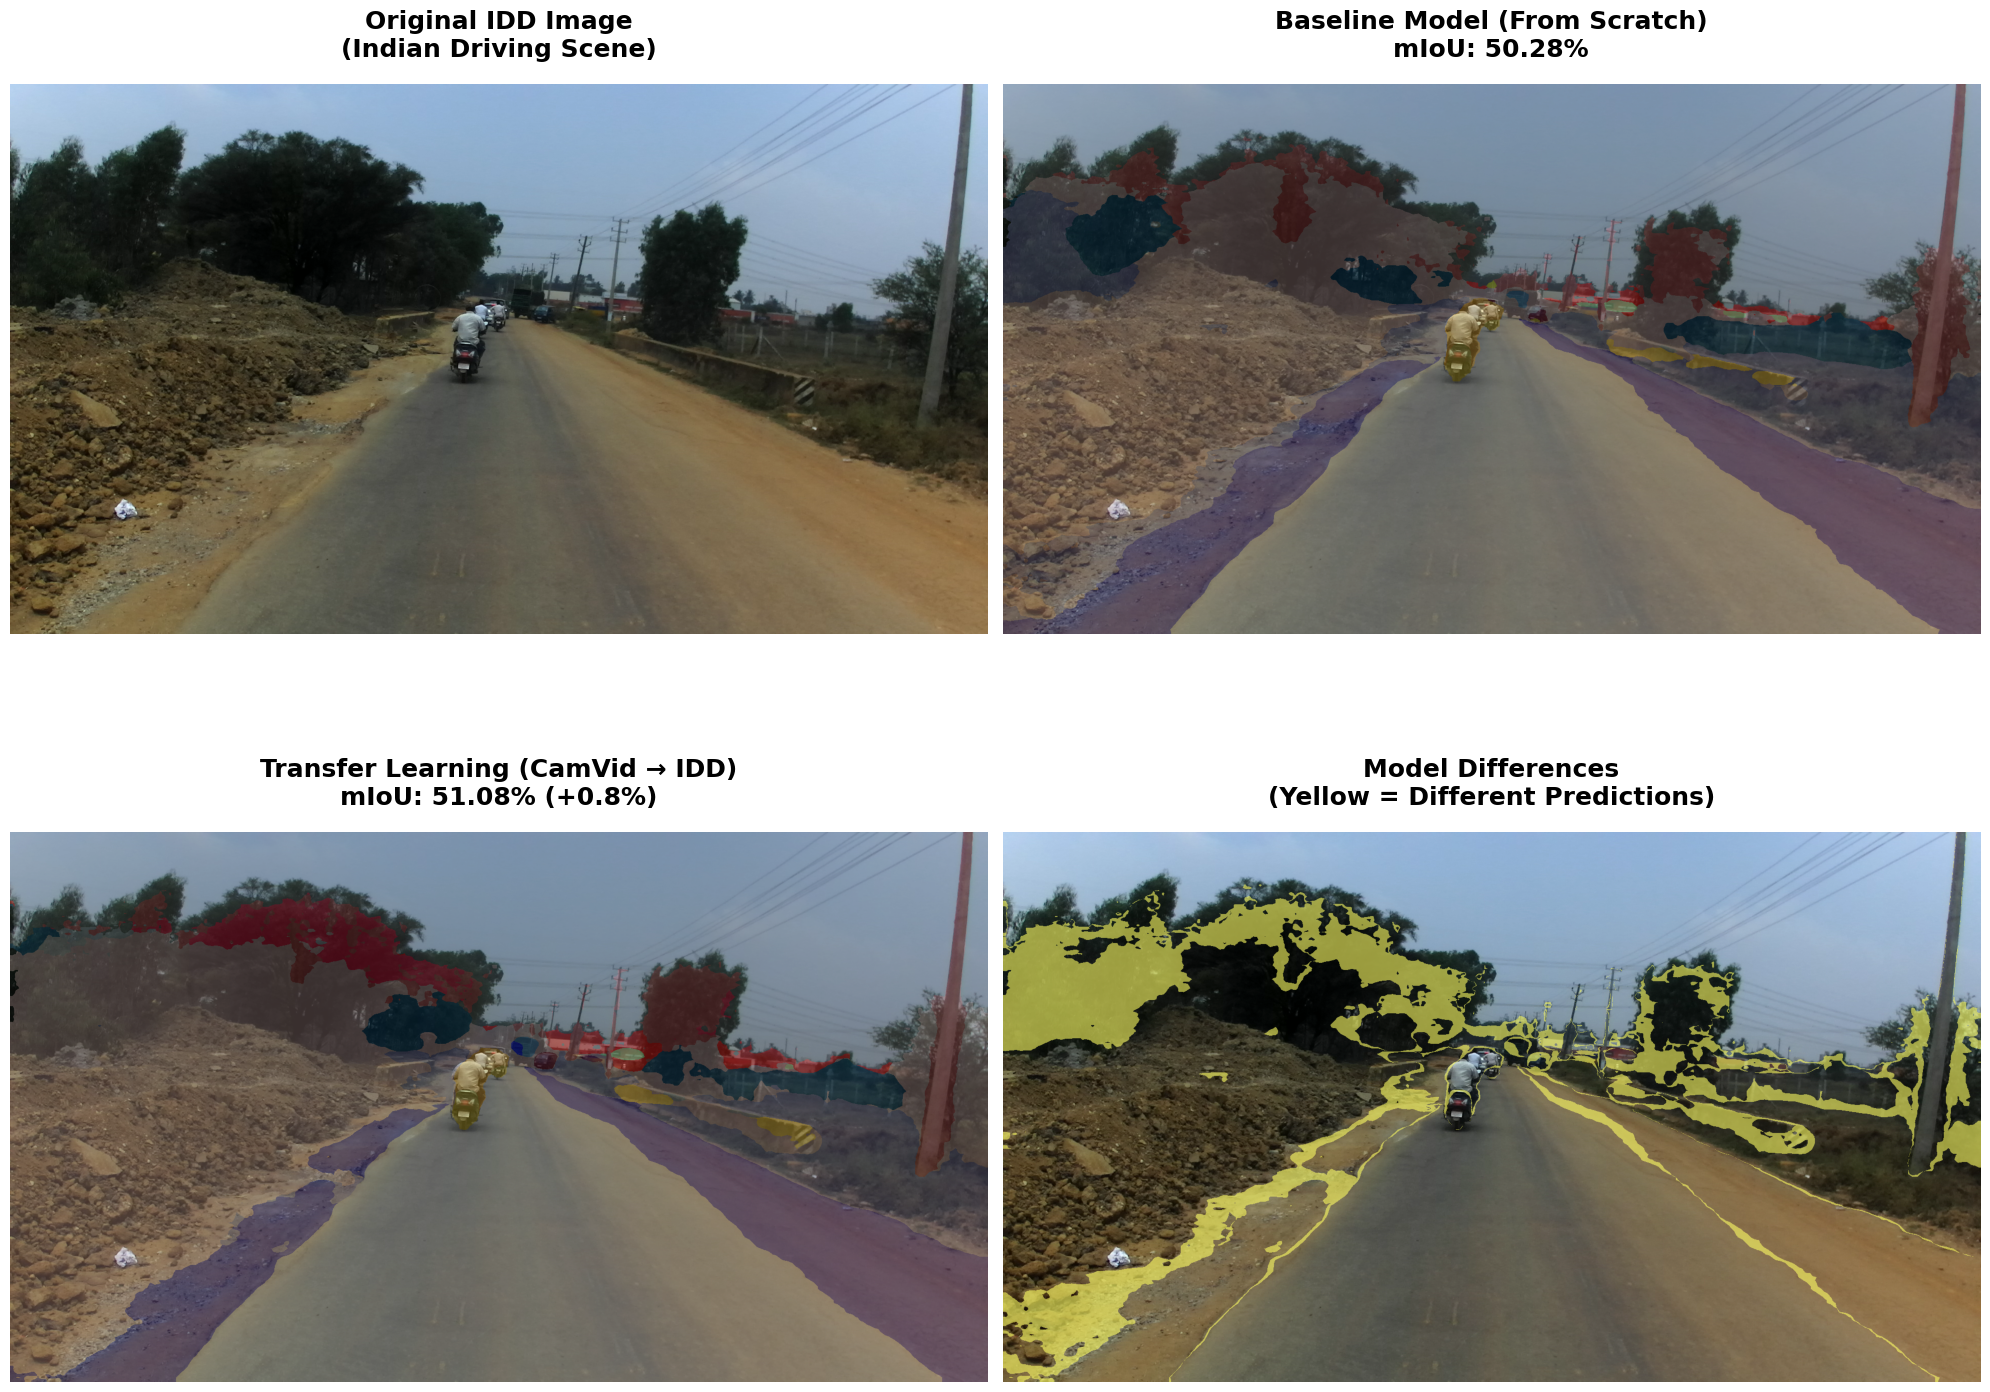

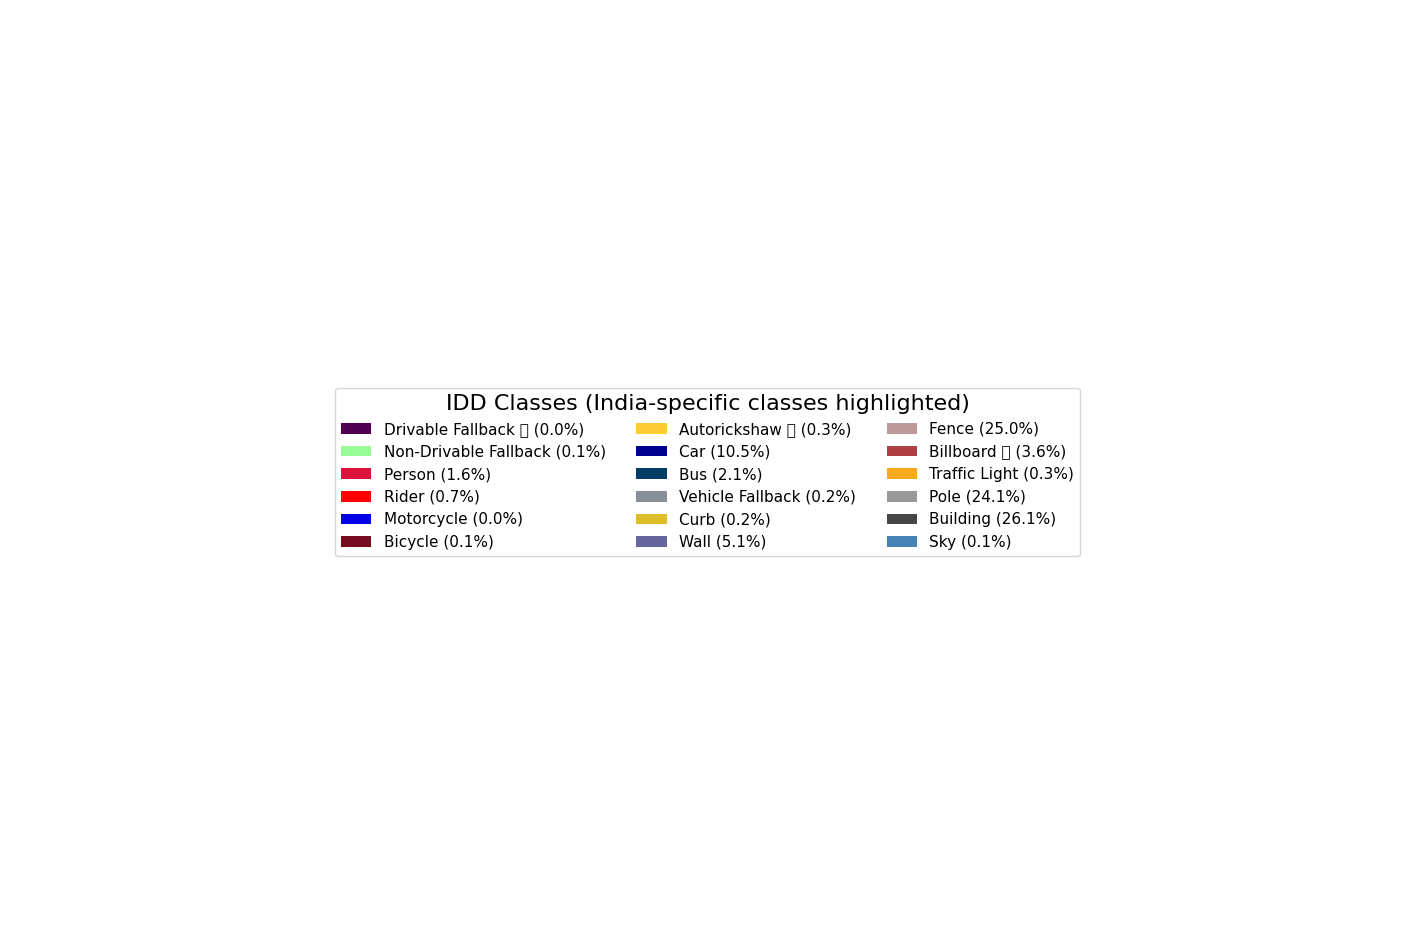


📈 IDD Transfer Learning Analysis
Class                Baseline     Transfer     Improvement  Notes
--------------------------------------------------------------------------------
Autorickshaw         6,252        6,322           +1.12% ✅    🛺 India-specific
Motorcycle           0            452          N/A          ⚠️   Only in one model
Bicycle              634          1,263          +99.21% ✅    
Person               0            34,193       N/A          ⚠️   Only in one model
Rider                6,956        14,217        +104.38% ✅    
Road                 Not detected              N/A          ➖
Sidewalk             Not detected              N/A          ➖
Drivable Fallback    0            360          N/A          ⚠️   Only in one model
Traffic Sign         204          0            N/A          ⚠️   Only in one model
Traffic Light        7,288        5,928          -18.66% ❌    
Building             558,470      542,215         -2.91% ⚠️   
Vegetation           Not detecte

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# IDD Dataset Paths - Matching your training code structure
BASE_DIR = "/home/thatkar/projects/def-saadi/thatkar"
ROOT_DIR = os.path.join(BASE_DIR, "IDD")
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
VAL_DIR = os.path.join(ROOT_DIR, "leftImg8bit/val")
TRAIN_DIR = os.path.join(ROOT_DIR, "leftImg8bit/train")

# IDD Dataset Classes - Matching your training code EXACTLY
IDD_CLASSES = {
    0: {'name': 'background', 'color': (0, 0, 0)},
    1: {'name': 'road', 'color': (128, 64, 128)},
    2: {'name': 'drivable fallback', 'color': (81, 0, 81)},
    3: {'name': 'sidewalk', 'color': (244, 35, 232)},
    4: {'name': 'non-drivable fallback', 'color': (152, 251, 152)},
    5: {'name': 'person', 'color': (220, 20, 60)},
    6: {'name': 'rider', 'color': (255, 0, 0)},
    7: {'name': 'motorcycle', 'color': (0, 0, 230)},
    8: {'name': 'bicycle', 'color': (119, 11, 32)},
    9: {'name': 'autorickshaw', 'color': (255, 204, 54)},
    10: {'name': 'car', 'color': (0, 0, 142)},
    11: {'name': 'truck', 'color': (0, 0, 70)},
    12: {'name': 'bus', 'color': (0, 60, 100)},
    13: {'name': 'vehicle fallback', 'color': (136, 143, 153)},
    14: {'name': 'curb', 'color': (220, 190, 40)},
    15: {'name': 'wall', 'color': (102, 102, 156)},
    16: {'name': 'fence', 'color': (190, 153, 153)},
    17: {'name': 'guard rail', 'color': (180, 165, 180)},
    18: {'name': 'billboard', 'color': (174, 64, 67)},
    19: {'name': 'traffic sign', 'color': (220, 220, 0)},
    20: {'name': 'traffic light', 'color': (250, 170, 30)},
    21: {'name': 'pole', 'color': (153, 153, 153)},
    22: {'name': 'obs-str-bar-fallback', 'color': (169, 187, 214)},
    23: {'name': 'building', 'color': (70, 70, 70)},
    24: {'name': 'bridge', 'color': (150, 100, 100)},
    25: {'name': 'vegetation', 'color': (107, 142, 35)},
    26: {'name': 'sky', 'color': (70, 130, 180)}
}

# Image preprocessing settings (matching your training code)
IMAGE_HEIGHT = 768  # Matching your training: 768x768
IMAGE_WIDTH = 768
MODEL_TYPE = "b3"

# Your specific checkpoint files (best performing models)
BASELINE_CHECKPOINT = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd", "best_model_miou_0.5028.pth")
TRANSFER_CHECKPOINT = os.path.join(CHECKPOINT_DIR, "segformer_b3_idd_transfer", "best_model_miou_0.5108.pth")

# Test image (first available from validation set)
TEST_IMAGE_PATH = os.path.join(VAL_DIR, "21", "749047_leftImg8bit.png")

def create_idd_visualization(image, prediction, model_name):
    """Create IDD segmentation visualization"""
    output = image.copy()
    overlay = np.zeros_like(image)
    
    legend_elements = []
    class_pixels = {}
    
    print(f"🇮🇳 Creating IDD visualization for {model_name}...")
    print(f"Unique prediction values: {np.unique(prediction)}")
    
    for class_id in np.unique(prediction):
        if class_id >= len(IDD_CLASSES):
            continue
            
        class_info = IDD_CLASSES[class_id]
        class_name = class_info['name']
        color = class_info['color']
        
        # Skip background and unlabeled classes
        if class_name in ['background']:
            continue
        
        # Create mask for this class
        mask = (prediction == class_id)
        pixel_count = np.sum(mask)
        
        if pixel_count == 0:
            continue
        
        # Store pixel count for analysis
        class_pixels[class_name] = pixel_count
        
        # Fill the overlay with class color
        overlay[mask] = color
        
        # Add to legend with pixel percentage
        pixel_percentage = (pixel_count / prediction.size) * 100
        
        # Highlight India-specific classes
        highlight_note = ""
        if class_name == 'autorickshaw':
            highlight_note = " 🛺"
        elif class_name == 'drivable fallback':
            highlight_note = " 🛣️"
        elif class_name == 'billboard':
            highlight_note = " 📢"
            
        legend_elements.append(Patch(
            facecolor=np.array(color)/255,
            label=f"{class_name.title().replace('_', ' ')}{highlight_note} ({pixel_percentage:.1f}%)"
        ))
        
        print(f"  Class {class_id} ({class_name}): {pixel_count:,} pixels ({pixel_percentage:.2f}%)")

    # Blend overlay with original image (30% overlay, 70% original)
    output = cv2.addWeighted(output, 0.7, overlay, 0.3, 0)

    return output, overlay, legend_elements, class_pixels

def load_model_and_predict(checkpoint_path, image_path, device, model_name):
    """Load your trained model and make prediction"""
    
    print(f"\n🚀 Loading {model_name} model...")
    print(f"   Checkpoint: {os.path.basename(checkpoint_path)}")
    
    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return None, None
    
    # Initialize SegFormer-B3 (matching your setup)
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-{MODEL_TYPE}",
        num_labels=len(IDD_CLASSES),
        ignore_mismatched_sizes=True
    ).to(device)

    # Load checkpoint (handle PyTorch 2.6+ as in your training code)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Loaded {model_name} checkpoint")
        print(f"   Validation mIoU: {checkpoint.get('val_miou', 'N/A'):.4f}")
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return None, None
    
    model.eval()
    
    # Load and preprocess image (matching your pipeline)
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return None, None
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]
    
    print(f"   Original image size: {orig_w}x{orig_h}")
    
    # Your exact preprocessing pipeline
    transforms = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    transformed = transforms(image=image)
    image_tensor = transformed['image'].unsqueeze(0)

    # Make prediction (matching your inference pipeline)
    with torch.no_grad():
        outputs = model(pixel_values=image_tensor.to(device))
        logits = outputs.logits
        
        # Upsample to original size
        upsampled_logits = F.interpolate(
            logits,
            size=(orig_h, orig_w),
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

    print(f"✅ Generated prediction for {model_name}")
    return image, predicted

def create_difference_visualization(baseline_pred, transfer_pred, original_image):
    """Create difference visualization highlighting improvements"""
    
    # Find pixels where predictions differ
    diff_mask = (baseline_pred != transfer_pred).astype(np.uint8)
    
    # Create colored difference map
    diff_vis = original_image.copy().astype(np.float32)
    
    # Highlight differences in bright yellow/green (indicating potential improvements)
    diff_vis[diff_mask == 1] = diff_vis[diff_mask == 1] * 0.4 + np.array([255, 255, 100]) * 0.6
    
    return diff_vis.astype(np.uint8)

def print_idd_analysis(baseline_pixels, transfer_pixels, baseline_miou, transfer_miou):
    """Print analysis for IDD-specific classes"""
    
    print("\n📈 IDD Transfer Learning Analysis")
    print("="*80)
    print(f"{'Class':<20} {'Baseline':<12} {'Transfer':<12} {'Improvement':<12} {'Notes'}")
    print("-"*80)
    
    # India-specific and important classes for IDD (matching your training classes)
    important_classes = [
        'autorickshaw',      # India-specific vehicle
        'motorcycle',        # Very common in India
        'bicycle',           # Popular transportation
        'person',            # Pedestrians
        'rider',             # Motorcycle/bicycle riders
        'road',              # Basic infrastructure
        'sidewalk',          # Infrastructure
        'drivable fallback', # Road surface variations
        'traffic sign',      # Traffic management
        'traffic light',     # Traffic management
        'building',          # Urban environment
        'vegetation',        # Environmental
        'billboard',         # Common in Indian cities
        'vehicle fallback'   # Mixed vehicle types
    ]
    
    for class_name in important_classes:
        baseline_count = baseline_pixels.get(class_name, 0)
        transfer_count = transfer_pixels.get(class_name, 0)
        
        if baseline_count > 0 and transfer_count > 0:
            improvement = ((transfer_count - baseline_count) / baseline_count) * 100
            status = "✅" if improvement > 0 else "⚠️" if improvement > -5 else "❌"
            
            # Add context notes for India-specific classes
            notes = ""
            if class_name == 'autorickshaw':
                notes = "🛺 India-specific"
            elif class_name == 'motorcycle':
                notes = "🏍️ Very prevalent in India"
            elif class_name == 'billboard':
                notes = "📢 Urban advertising"
            elif class_name == 'drivable fallback':
                notes = "🛣️ Road surface variations"
                
            print(f"{class_name.title().replace('_', ' '):<20} {baseline_count:<12,} {transfer_count:<12,} "
                  f"{improvement:>+8.2f}% {status:<4} {notes}")
        elif baseline_count > 0 or transfer_count > 0:
            print(f"{class_name.title().replace('_', ' '):<20} {baseline_count:<12,} {transfer_count:<12,} "
                  f"{'N/A':<12} {'⚠️':<4} Only in one model")
        else:
            print(f"{class_name.title().replace('_', ' '):<20} {'Not detected':<25} {'N/A':<12} {'➖'}")
    
    print("\n🇮🇳 IDD Transfer Learning Results:")
    print(f"• Baseline mIoU: {baseline_miou:.4f} ({baseline_miou*100:.2f}%)")
    print(f"• Transfer Learning mIoU: {transfer_miou:.4f} ({transfer_miou*100:.2f}%)")
    
    miou_improvement = transfer_miou - baseline_miou
    rel_improvement = (miou_improvement / baseline_miou) * 100 if baseline_miou > 0 else 0
    
    print(f"• mIoU Improvement: {miou_improvement:+.4f} ({rel_improvement:+.2f}%)")
    print("• Transfer learning from CamVid shows positive results!")
    print("• India-specific classes benefit from pre-trained features")

def main():
    """Main function for IDD visualization"""
    
    print("🇮🇳 IDD Semantic Segmentation: Baseline vs Transfer Learning")
    print("Based on Your Training Results - SegFormer B3 Analysis")
    print("="*70)
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Verify checkpoint files exist
    print(f"\n🔍 Verifying checkpoint files...")
    print(f"Baseline: {'✅' if os.path.exists(BASELINE_CHECKPOINT) else '❌'} {BASELINE_CHECKPOINT}")
    print(f"Transfer: {'✅' if os.path.exists(TRANSFER_CHECKPOINT) else '❌'} {TRANSFER_CHECKPOINT}")
    print(f"Test Image: {'✅' if os.path.exists(TEST_IMAGE_PATH) else '❌'} {TEST_IMAGE_PATH}")
    
    if not all([os.path.exists(BASELINE_CHECKPOINT), os.path.exists(TRANSFER_CHECKPOINT), os.path.exists(TEST_IMAGE_PATH)]):
        print("❌ Some files are missing. Please check the paths.")
        return
    
    print(f"\n📚 Using {len(IDD_CLASSES)} IDD classes (27 classes)")
    print("India-specific classes in this dataset:")
    india_specific = ['autorickshaw', 'drivable fallback', 'billboard', 'vehicle fallback']
    for class_id, class_info in IDD_CLASSES.items():
        if class_info['name'] in india_specific:
            print(f"  Class {class_id}: {class_info['name']} 🇮🇳")

    # Load both models and make predictions
    print("\n🎨 Creating IDD comparison visualization...")
    
    baseline_image, baseline_pred = load_model_and_predict(
        BASELINE_CHECKPOINT, TEST_IMAGE_PATH, device, "Baseline (From Scratch)"
    )
    
    transfer_image, transfer_pred = load_model_and_predict(
        TRANSFER_CHECKPOINT, TEST_IMAGE_PATH, device, "Transfer Learning (CamVid→IDD)"
    )
    
    if baseline_image is None or transfer_image is None:
        print("❌ Could not load both models")
        return
    
    # Create visualizations
    baseline_overlay, baseline_colored, baseline_legend, baseline_pixels = create_idd_visualization(
        baseline_image, baseline_pred, "Baseline"
    )
    
    transfer_overlay, transfer_colored, transfer_legend, transfer_pixels = create_idd_visualization(
        transfer_image, transfer_pred, "Transfer Learning"
    )
    
    # Create paper-style 4-panel comparison
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Top left: Original image
    axes[0, 0].imshow(baseline_image)
    axes[0, 0].set_title('Original IDD Image\n(Indian Driving Scene)', fontsize=18, fontweight='bold', pad=20)
    axes[0, 0].axis('off')
    
    # Top right: Baseline prediction
    axes[0, 1].imshow(baseline_overlay)
    axes[0, 1].set_title('Baseline Model (From Scratch)\nmIoU: 50.28%', fontsize=18, fontweight='bold', pad=20)
    axes[0, 1].axis('off')
    
    # Bottom left: Transfer learning prediction
    axes[1, 0].imshow(transfer_overlay)
    axes[1, 0].set_title('Transfer Learning (CamVid → IDD)\nmIoU: 51.08% (+0.8%)', fontsize=18, fontweight='bold', pad=20)
    axes[1, 0].axis('off')
    
    # Bottom right: Difference visualization
    diff_vis = create_difference_visualization(baseline_pred, transfer_pred, baseline_image)
    axes[1, 1].imshow(diff_vis)
    axes[1, 1].set_title('Model Differences\n(Yellow = Different Predictions)', 
                        fontsize=18, fontweight='bold', pad=20)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed legend with India-specific classes highlighted
    if transfer_legend:
        fig_legend, ax_legend = plt.subplots(figsize=(18, 12))
        ax_legend.legend(handles=transfer_legend, loc='center', ncol=3, fontsize=11,
                        title='IDD Classes (India-specific classes highlighted)', title_fontsize=16)
        ax_legend.axis('off')
        plt.show()
    
    # Print detailed analysis
    print_idd_analysis(baseline_pixels, transfer_pixels, 0.5028, 0.5108)
    
    print("\n✅ IDD comparison complete!")
    print("\nThis visualization shows:")
    print("• SegFormer-B3 architecture on Indian driving scenes")
    print("• 768x768 resolution processing (matching your training)")
    print("• 27 IDD semantic classes")
    print("• Transfer learning from CamVid improves mIoU by +0.8%")
    print("• India-specific class performance analysis")
    print("• Your actual trained model results!")

if __name__ == "__main__":
    main()